In [112]:

import pandas as pd
import numpy as np
import pickle
from datetime import datetime

import sys
sys.path.insert(0, "..")   
from src.model_utils import train, ShallowNN, TwoLayerNN, ResidualMLP
from src.utils import build_feature_and_label_cols
from src.plot_util import plot_all_sids_losses, plot_loss_per_sid, plot_median_iqr_loss, plot_final_percent_mav_per_sid



In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-06-09'

In [101]:
# load
df = pd.read_excel("../output/data/20250607_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx")
df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_season_cos_7,y_season_cos_8,y_season_cos_9,y_season_cos_10,y_season_cos_11,y_season_cos_12,y_season_cos_13,y_season_cos_14,y_season_cos_15,y_season_cos_16
0,2013-01-09,3_1047679,3,1047679,398.0,520.0,543.0,910.0,784.0,467.0,...,0.677615,0.690173,0.702527,0.714673,0.726608,0.738326,0.749826,0.761104,0.772157,0.782980
1,2013-01-25,3_1047679,3,1047679,224.0,520.0,474.0,251.0,302.0,288.0,...,0.852078,0.860961,0.869589,0.877960,0.886071,0.893919,0.901502,0.908818,0.915864,0.922640
2,2013-02-10,3_1047679,3,1047679,245.0,308.0,243.0,286.0,231.0,267.0,...,0.962309,0.966848,0.971100,0.975065,0.978740,0.982126,0.985220,0.988023,0.990532,0.992749
3,2013-02-26,3_1047679,3,1047679,173.0,352.0,231.0,292.0,525.0,736.0,...,1.000000,0.999852,0.999407,0.998667,0.997630,0.996298,0.994671,0.992749,0.990532,0.988023
4,2013-03-14,3_1047679,3,1047679,429.0,419.0,504.0,623.0,293.0,250.0,...,0.962309,0.957485,0.952378,0.946988,0.941317,0.935368,0.929141,0.922640,0.915864,0.908818


In [102]:
df["start_date"].min(), df["start_date"].max()

(Timestamp('2013-01-09 00:00:00'), Timestamp('2017-07-15 00:00:00'))

In [103]:
df.dtypes

start_date         datetime64[ns]
store_item                 object
store                       int64
item                        int64
sales_day_1               float64
                        ...      
y_season_cos_12           float64
y_season_cos_13           float64
y_season_cos_14           float64
y_season_cos_15           float64
y_season_cos_16           float64
Length: 420, dtype: object

In [104]:
df.columns

Index(['start_date', 'store_item', 'store', 'item', 'sales_day_1',
       'sales_day_2', 'sales_day_3', 'sales_day_4', 'sales_day_5',
       'sales_day_6',
       ...
       'y_season_cos_7', 'y_season_cos_8', 'y_season_cos_9', 'y_season_cos_10',
       'y_season_cos_11', 'y_season_cos_12', 'y_season_cos_13',
       'y_season_cos_14', 'y_season_cos_15', 'y_season_cos_16'],
      dtype='object', length=420)

In [105]:
df.shape

(10386, 420)

In [106]:
window_size = 16
meta_cols,\
x_sales_features,\
x_cyclical_features,\
x_feature_cols,\
label_cols,\
y_sales_features,\
y_cyclical_features = build_feature_and_label_cols(window_size)



In [107]:
print(len(meta_cols))
print(len(x_feature_cols))
print(len(label_cols))
assert df.columns.to_list() == meta_cols + x_feature_cols + label_cols

4
208
208


In [108]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [110]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [130]:
hist_df, summary_df, models_dict = train(
    df            = df,
    weights_df    = weights_df,
    x_feature_cols  = x_feature_cols,
    x_sales_features = x_sales_features,
    x_cyclical_features = x_cyclical_features,
    label_cols    = label_cols,
    y_cyclical_features = y_cyclical_features,
    y_sales_features = y_sales_features,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 64,
    lr            = 3e-4,
    epochs        = 100,
    seed          = 2025,
    model_cls     = TwoLayerNN,
    )    

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_1047679] Epoch 1/100 train_loss 4.0536, train_MAE 128.7627, train_%MAV 59.0043, test_loss 0.2695, test_MAE 114.0760, test_%MAV 60.2553, train_MPE 29508079.3920, test_MPE 3660962.4615
[3_1047679] Epoch 2/100 train_loss 4.0101, train_MAE 127.6403, train_%MAV 58.4900, test_loss 0.2640, test_MAE 112.3811, test_%MAV 59.3601, train_MPE 30924122.8693, test_MPE 3391272.7912
[3_1047679] Epoch 3/100 train_loss 3.9710, train_MAE 126.8605, train_%MAV 58.1327, test_loss 0.2602, test_MAE 111.0339, test_%MAV 58.6485, train_MPE 33005921.0380, test_MPE 3009270.6227
[3_1047679] Epoch 4/100 train_loss 3.9337, train_MAE 126.1889, train_%MAV 57.8249, test_loss 0.2582, test_MAE 110.3212, test_%MAV 58.2720, train_MPE 33672466.2688, test_MPE 2649338.3736
[3_1047679] Epoch 5/100 train_loss 3.8980, train_MAE 125.7103, train_%MAV 57.6056, test_loss 0.2571, test_MAE 109.9362, test_%MAV 58.0687, train_MPE 34542510.8582, test_MPE 2328703.2967
[3_1047679] Epoch 6/100 train_loss 3.8634, train_MAE 125.3338, train_%

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_114790] Epoch 1/100 train_loss 4.0126, train_MAE 19.7409, train_%MAV 49.3724, test_loss 0.2682, test_MAE 22.6778, test_%MAV 54.7172, train_MPE 12476343.3994, test_MPE 1417437.5385
[3_114790] Epoch 2/100 train_loss 3.9683, train_MAE 19.4850, train_%MAV 48.7323, test_loss 0.2648, test_MAE 22.4485, test_%MAV 54.1640, train_MPE 12352691.8406, test_MPE 1496616.0879
[3_114790] Epoch 3/100 train_loss 3.9278, train_MAE 19.2899, train_%MAV 48.2445, test_loss 0.2626, test_MAE 22.2613, test_%MAV 53.7122, train_MPE 12391498.0241, test_MPE 1589710.3004
[3_114790] Epoch 4/100 train_loss 3.8884, train_MAE 19.1524, train_%MAV 47.9006, test_loss 0.2612, test_MAE 22.1719, test_%MAV 53.4967, train_MPE 12411963.3142, test_MPE 1694012.8352
[3_114790] Epoch 5/100 train_loss 3.8505, train_MAE 19.0380, train_%MAV 47.6144, test_loss 0.2602, test_MAE 22.0986, test_%MAV 53.3198, train_MPE 12490194.4467, test_MPE 1936618.1978
[3_114790] Epoch 6/100 train_loss 3.8142, train_MAE 18.9375, train_%MAV 47.3631, test

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_305229] Epoch 1/100 train_loss 4.0681, train_MAE 27.1370, train_%MAV 48.4938, test_loss 0.2630, test_MAE 25.7474, test_%MAV 50.1278, train_MPE 9138196.6413, test_MPE 1197348.6886
[3_305229] Epoch 2/100 train_loss 4.0229, train_MAE 26.8230, train_%MAV 47.9326, test_loss 0.2611, test_MAE 25.5269, test_%MAV 49.6984, train_MPE 9485200.4893, test_MPE 1180097.6410
[3_305229] Epoch 3/100 train_loss 3.9818, train_MAE 26.6026, train_%MAV 47.5388, test_loss 0.2598, test_MAE 25.3600, test_%MAV 49.3735, train_MPE 9717381.3383, test_MPE 1305831.7363
[3_305229] Epoch 4/100 train_loss 3.9427, train_MAE 26.4336, train_%MAV 47.2368, test_loss 0.2587, test_MAE 25.2281, test_%MAV 49.1166, train_MPE 9926288.4893, test_MPE 1318245.2747
[3_305229] Epoch 5/100 train_loss 3.9049, train_MAE 26.2997, train_%MAV 46.9975, test_loss 0.2580, test_MAE 25.1309, test_%MAV 48.9274, train_MPE 10020599.6960, test_MPE 1284391.6190
[3_305229] Epoch 6/100 train_loss 3.8685, train_MAE 26.1803, train_%MAV 46.7842, test_los

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_314384] Epoch 1/100 train_loss 3.9466, train_MAE 43.4874, train_%MAV 49.4873, test_loss 0.2650, test_MAE 40.0682, test_%MAV 52.3662, train_MPE 20982754.1057, test_MPE 467962.0806
[3_314384] Epoch 2/100 train_loss 3.9028, train_MAE 43.0761, train_%MAV 49.0192, test_loss 0.2619, test_MAE 39.7099, test_%MAV 51.8979, train_MPE 21928206.9472, test_MPE 41386.4322
[3_314384] Epoch 3/100 train_loss 3.8639, train_MAE 42.6835, train_%MAV 48.5725, test_loss 0.2595, test_MAE 39.3852, test_%MAV 51.4735, train_MPE 22539971.9741, test_MPE 169625.5824
[3_314384] Epoch 4/100 train_loss 3.8269, train_MAE 42.3008, train_%MAV 48.1370, test_loss 0.2578, test_MAE 39.0843, test_%MAV 51.0803, train_MPE 22716825.0306, test_MPE 233073.8755
[3_314384] Epoch 5/100 train_loss 3.7918, train_MAE 41.9444, train_%MAV 47.7314, test_loss 0.2565, test_MAE 38.8503, test_%MAV 50.7745, train_MPE 23170123.4476, test_MPE 234774.2125
[3_314384] Epoch 6/100 train_loss 3.7584, train_MAE 41.6193, train_%MAV 47.3614, test_loss 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_364606] Epoch 1/100 train_loss 4.0120, train_MAE 46.8441, train_%MAV 51.6259, test_loss 0.2695, test_MAE 43.6460, test_%MAV 53.0660, train_MPE 23284321.2753, test_MPE 3102470.5641
[3_364606] Epoch 2/100 train_loss 3.9691, train_MAE 46.2598, train_%MAV 50.9819, test_loss 0.2643, test_MAE 43.0618, test_%MAV 52.3557, train_MPE 21253201.6163, test_MPE 2082931.3407
[3_364606] Epoch 3/100 train_loss 3.9305, train_MAE 45.8527, train_%MAV 50.5332, test_loss 0.2606, test_MAE 42.6877, test_%MAV 51.9008, train_MPE 19252533.3828, test_MPE 1210352.5275
[3_364606] Epoch 4/100 train_loss 3.8934, train_MAE 45.6148, train_%MAV 50.2711, test_loss 0.2578, test_MAE 42.4196, test_%MAV 51.5750, train_MPE 17186112.7711, test_MPE 428589.5385
[3_364606] Epoch 5/100 train_loss 3.8574, train_MAE 45.3623, train_%MAV 49.9928, test_loss 0.2559, test_MAE 42.2362, test_%MAV 51.3519, train_MPE 15775405.1974, test_MPE 275384.9084
[3_364606] Epoch 6/100 train_loss 3.8226, train_MAE 45.1468, train_%MAV 49.7552, test_l

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_502331] Epoch 7/100 train_loss 3.7218, train_MAE 33.5910, train_%MAV 47.1337, test_loss 0.2518, test_MAE 30.2370, test_%MAV 48.5998, train_MPE 13670228.2261, test_MPE 933733.6264
[3_502331] Epoch 8/100 train_loss 3.6888, train_MAE 33.5088, train_%MAV 47.0183, test_loss 0.2510, test_MAE 30.2092, test_%MAV 48.5551, train_MPE 13762137.6830, test_MPE 804559.7070
[3_502331] Epoch 9/100 train_loss 3.6574, train_MAE 33.4141, train_%MAV 46.8853, test_loss 0.2503, test_MAE 30.2382, test_%MAV 48.6018, train_MPE 13865798.9398, test_MPE 724464.8791
[3_502331] Epoch 10/100 train_loss 3.6275, train_MAE 33.3142, train_%MAV 46.7452, test_loss 0.2496, test_MAE 30.2307, test_%MAV 48.5897, train_MPE 14073274.7210, test_MPE 660809.1429
[3_502331] Epoch 11/100 train_loss 3.5989, train_MAE 33.2087, train_%MAV 46.5972, test_loss 0.2491, test_MAE 30.1981, test_%MAV 48.5373, train_MPE 14284781.4940, test_MPE 584339.2234
[3_502331] Epoch 12/100 train_loss 3.5714, train_MAE 33.1000, train_%MAV 46.4447, test_l

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_567623] Epoch 8/100 train_loss 3.6845, train_MAE 18.9058, train_%MAV 46.0305, test_loss 0.2522, test_MAE 23.5047, test_%MAV 50.8886, train_MPE 12007999.5848, test_MPE 2129234.7546
[3_567623] Epoch 9/100 train_loss 3.6552, train_MAE 18.8401, train_%MAV 45.8706, test_loss 0.2518, test_MAE 23.4669, test_%MAV 50.8069, train_MPE 12274443.1511, test_MPE 2356046.5348
[3_567623] Epoch 10/100 train_loss 3.6268, train_MAE 18.7592, train_%MAV 45.6737, test_loss 0.2513, test_MAE 23.4110, test_%MAV 50.6859, train_MPE 12607332.3596, test_MPE 2546307.5165
[3_567623] Epoch 11/100 train_loss 3.5989, train_MAE 18.6714, train_%MAV 45.4598, test_loss 0.2508, test_MAE 23.3442, test_%MAV 50.5412, train_MPE 12935943.8295, test_MPE 2697896.7912
[3_567623] Epoch 12/100 train_loss 3.5717, train_MAE 18.5766, train_%MAV 45.2291, test_loss 0.2503, test_MAE 23.2687, test_%MAV 50.3777, train_MPE 13317275.6404, test_MPE 2808091.1941
[3_567623] Epoch 13/100 train_loss 3.5453, train_MAE 18.4748, train_%MAV 44.9811, 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_581078] Epoch 7/100 train_loss 3.7516, train_MAE 16.6453, train_%MAV 45.1220, test_loss 0.2572, test_MAE 17.8590, test_%MAV 49.6493, train_MPE 8689185.6905, test_MPE 1060679.3846
[3_581078] Epoch 8/100 train_loss 3.7176, train_MAE 16.5649, train_%MAV 44.9042, test_loss 0.2569, test_MAE 17.8599, test_%MAV 49.6518, train_MPE 8430702.0871, test_MPE 797443.2821
[3_581078] Epoch 9/100 train_loss 3.6855, train_MAE 16.4829, train_%MAV 44.6820, test_loss 0.2566, test_MAE 17.8475, test_%MAV 49.6174, train_MPE 8328144.5487, test_MPE 561153.5238
[3_581078] Epoch 10/100 train_loss 3.6551, train_MAE 16.4063, train_%MAV 44.4741, test_loss 0.2562, test_MAE 17.8246, test_%MAV 49.5538, train_MPE 8317850.4541, test_MPE 377337.9048
[3_581078] Epoch 11/100 train_loss 3.6264, train_MAE 16.3371, train_%MAV 44.2866, test_loss 0.2557, test_MAE 17.7970, test_%MAV 49.4770, train_MPE 8276689.9722, test_MPE 226413.9487
[3_581078] Epoch 12/100 train_loss 3.5990, train_MAE 16.2716, train_%MAV 44.1090, test_loss 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_582864] Epoch 12/100 train_loss 3.6510, train_MAE 36.8688, train_%MAV 56.8025, test_loss 0.2517, test_MAE 41.8376, test_%MAV 59.8638, train_MPE 20228838.6135, test_MPE 11704380.9524
[3_582864] Epoch 13/100 train_loss 3.6228, train_MAE 36.7721, train_%MAV 56.6535, test_loss 0.2509, test_MAE 41.6825, test_%MAV 59.6419, train_MPE 20504202.0834, test_MPE 11712681.7289
[3_582864] Epoch 14/100 train_loss 3.5956, train_MAE 36.6890, train_%MAV 56.5254, test_loss 0.2501, test_MAE 41.5273, test_%MAV 59.4197, train_MPE 20851538.3281, test_MPE 11708385.9927
[3_582864] Epoch 15/100 train_loss 3.5691, train_MAE 36.5880, train_%MAV 56.3699, test_loss 0.2492, test_MAE 41.3599, test_%MAV 59.1802, train_MPE 21064640.8897, test_MPE 11690624.4689
[3_582864] Epoch 16/100 train_loss 3.5435, train_MAE 36.4638, train_%MAV 56.1785, test_loss 0.2481, test_MAE 41.1862, test_%MAV 58.9318, train_MPE 21143641.2085, test_MPE 11631214.6520
[3_582864] Epoch 17/100 train_loss 3.5188, train_MAE 36.3143, train_%MAV 55

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[3_584028] Epoch 8/100 train_loss 3.7341, train_MAE 37.8537, train_%MAV 48.9103, test_loss 0.2566, test_MAE 35.7094, test_%MAV 49.8061, train_MPE 25778164.6117, test_MPE 1969483.2527
[3_584028] Epoch 9/100 train_loss 3.7025, train_MAE 37.7777, train_%MAV 48.8120, test_loss 0.2560, test_MAE 35.6844, test_%MAV 49.7712, train_MPE 25963431.7405, test_MPE 1873290.1978
[3_584028] Epoch 10/100 train_loss 3.6719, train_MAE 37.7131, train_%MAV 48.7285, test_loss 0.2553, test_MAE 35.6790, test_%MAV 49.7638, train_MPE 26259759.6886, test_MPE 1704773.9780
[3_584028] Epoch 11/100 train_loss 3.6423, train_MAE 37.6633, train_%MAV 48.6643, test_loss 0.2546, test_MAE 35.6842, test_%MAV 49.7710, train_MPE 26462508.8415, test_MPE 1522835.5751
[3_584028] Epoch 12/100 train_loss 3.6137, train_MAE 37.6048, train_%MAV 48.5886, test_loss 0.2539, test_MAE 35.6788, test_%MAV 49.7634, train_MPE 26667801.3865, test_MPE 1348572.3663
[3_584028] Epoch 13/100 train_loss 3.5859, train_MAE 37.5365, train_%MAV 48.5004, 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_1047679] Epoch 3/100 train_loss 3.9099, train_MAE 134.0904, train_%MAV 55.7207, test_loss 0.2555, test_MAE 117.5028, test_%MAV 60.3348, train_MPE 22416865.6311, test_MPE 5892608.9377
[44_1047679] Epoch 4/100 train_loss 3.8715, train_MAE 134.2706, train_%MAV 55.7956, test_loss 0.2543, test_MAE 117.6478, test_%MAV 60.4092, train_MPE 20480204.0408, test_MPE 5242558.8278
[44_1047679] Epoch 5/100 train_loss 3.8349, train_MAE 134.4509, train_%MAV 55.8705, test_loss 0.2534, test_MAE 117.6237, test_%MAV 60.3969, train_MPE 18845235.2475, test_MPE 4656199.2674
[44_1047679] Epoch 6/100 train_loss 3.7999, train_MAE 134.7327, train_%MAV 55.9876, test_loss 0.2527, test_MAE 117.3340, test_%MAV 60.2481, train_MPE 17896979.9296, test_MPE 4222827.8388
[44_1047679] Epoch 7/100 train_loss 3.7662, train_MAE 134.9120, train_%MAV 56.0621, test_loss 0.2522, test_MAE 117.0655, test_%MAV 60.1102, train_MPE 17475649.4829, test_MPE 3925904.8791
[44_1047679] Epoch 8/100 train_loss 3.7337, train_MAE 135.0286, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_114790] Epoch 5/100 train_loss 3.8418, train_MAE 20.9109, train_%MAV 48.1367, test_loss 0.2618, test_MAE 26.0249, test_%MAV 53.3877, train_MPE 16237261.1890, test_MPE 8350569.9634
[44_114790] Epoch 6/100 train_loss 3.8031, train_MAE 20.7169, train_%MAV 47.6900, test_loss 0.2613, test_MAE 25.8133, test_%MAV 52.9538, train_MPE 16999885.9183, test_MPE 8643568.9963
[44_114790] Epoch 7/100 train_loss 3.7662, train_MAE 20.5574, train_%MAV 47.3229, test_loss 0.2608, test_MAE 25.6538, test_%MAV 52.6264, train_MPE 17631419.6847, test_MPE 9078583.3260
[44_114790] Epoch 8/100 train_loss 3.7315, train_MAE 20.4202, train_%MAV 47.0069, test_loss 0.2603, test_MAE 25.4894, test_%MAV 52.2891, train_MPE 18384429.7056, test_MPE 9528872.3223
[44_114790] Epoch 9/100 train_loss 3.6985, train_MAE 20.2893, train_%MAV 46.7058, test_loss 0.2598, test_MAE 25.3677, test_%MAV 52.0395, train_MPE 19262853.4701, test_MPE 9912832.0000
[44_114790] Epoch 10/100 train_loss 3.6672, train_MAE 20.1700, train_%MAV 46.431

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_305229] Epoch 1/100 train_loss 3.9644, train_MAE 28.4841, train_%MAV 52.6358, test_loss 0.2628, test_MAE 28.6849, test_%MAV 53.4842, train_MPE 19886437.3086, test_MPE 22149303.7949
[44_305229] Epoch 2/100 train_loss 3.9202, train_MAE 28.0910, train_%MAV 51.9093, test_loss 0.2597, test_MAE 28.4439, test_%MAV 53.0350, train_MPE 19301600.9194, test_MPE 22714673.6996
[44_305229] Epoch 3/100 train_loss 3.8804, train_MAE 27.7905, train_%MAV 51.3540, test_loss 0.2577, test_MAE 28.2437, test_%MAV 52.6616, train_MPE 19174156.1001, test_MPE 23277961.8462
[44_305229] Epoch 4/100 train_loss 3.8424, train_MAE 27.5404, train_%MAV 50.8919, test_loss 0.2565, test_MAE 27.9820, test_%MAV 52.1737, train_MPE 19299232.1483, test_MPE 22895799.7949
[44_305229] Epoch 5/100 train_loss 3.8067, train_MAE 27.3463, train_%MAV 50.5332, test_loss 0.2557, test_MAE 27.7972, test_%MAV 51.8291, train_MPE 19281038.3540, test_MPE 23069191.5018
[44_305229] Epoch 6/100 train_loss 3.7723, train_MAE 27.1721, train_%MAV 50

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_314384] Epoch 6/100 train_loss 3.7958, train_MAE 45.2241, train_%MAV 50.0562, test_loss 0.2563, test_MAE 42.4724, test_%MAV 52.7000, train_MPE 24029937.5273, test_MPE 12634418.6374
[44_314384] Epoch 7/100 train_loss 3.7597, train_MAE 44.9911, train_%MAV 49.7983, test_loss 0.2556, test_MAE 42.3866, test_%MAV 52.5936, train_MPE 25171455.5255, test_MPE 13011611.6630
[44_314384] Epoch 8/100 train_loss 3.7250, train_MAE 44.7620, train_%MAV 49.5447, test_loss 0.2549, test_MAE 42.3490, test_%MAV 52.5469, train_MPE 26685651.6330, test_MPE 13467755.8388
[44_314384] Epoch 9/100 train_loss 3.6917, train_MAE 44.5329, train_%MAV 49.2911, test_loss 0.2541, test_MAE 42.3749, test_%MAV 52.5791, train_MPE 28018241.0083, test_MPE 13877976.6154
[44_314384] Epoch 10/100 train_loss 3.6600, train_MAE 44.2820, train_%MAV 49.0135, test_loss 0.2533, test_MAE 42.4021, test_%MAV 52.6128, train_MPE 29084776.3930, test_MPE 14272033.7582
[44_314384] Epoch 11/100 train_loss 3.6298, train_MAE 44.0484, train_%MAV 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_364606] Epoch 7/100 train_loss 3.7970, train_MAE 51.5054, train_%MAV 54.3330, test_loss 0.2537, test_MAE 49.3899, test_%MAV 59.9816, train_MPE 16814499.4699, test_MPE 4974123.1355
[44_364606] Epoch 8/100 train_loss 3.7649, train_MAE 51.6043, train_%MAV 54.4374, test_loss 0.2535, test_MAE 49.5997, test_%MAV 60.2364, train_MPE 16593352.4819, test_MPE 4871290.3736
[44_364606] Epoch 9/100 train_loss 3.7341, train_MAE 51.7106, train_%MAV 54.5494, test_loss 0.2532, test_MAE 49.7704, test_%MAV 60.4438, train_MPE 16147059.7813, test_MPE 4674844.1319
[44_364606] Epoch 10/100 train_loss 3.7046, train_MAE 51.7828, train_%MAV 54.6256, test_loss 0.2528, test_MAE 49.9049, test_%MAV 60.6071, train_MPE 15904891.8480, test_MPE 4578309.1575
[44_364606] Epoch 11/100 train_loss 3.6763, train_MAE 51.8259, train_%MAV 54.6711, test_loss 0.2524, test_MAE 50.0216, test_%MAV 60.7488, train_MPE 15853728.8601, test_MPE 4384888.9670
[44_364606] Epoch 12/100 train_loss 3.6489, train_MAE 51.8413, train_%MAV 54.6

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_502331] Epoch 8/100 train_loss 3.7410, train_MAE 37.4360, train_%MAV 49.3108, test_loss 0.2605, test_MAE 36.9531, test_%MAV 52.8861, train_MPE 15882659.4699, test_MPE 14214093.3626
[44_502331] Epoch 9/100 train_loss 3.7080, train_MAE 37.2556, train_%MAV 49.0731, test_loss 0.2599, test_MAE 36.8675, test_%MAV 52.7636, train_MPE 16229534.4875, test_MPE 14127737.9048
[44_502331] Epoch 10/100 train_loss 3.6764, train_MAE 37.1032, train_%MAV 48.8723, test_loss 0.2593, test_MAE 36.7775, test_%MAV 52.6347, train_MPE 16500719.3920, test_MPE 13992878.4176
[44_502331] Epoch 11/100 train_loss 3.6459, train_MAE 36.9596, train_%MAV 48.6833, test_loss 0.2586, test_MAE 36.7001, test_%MAV 52.5241, train_MPE 16746044.2632, test_MPE 13850721.5238
[44_502331] Epoch 12/100 train_loss 3.6164, train_MAE 36.8074, train_%MAV 48.4827, test_loss 0.2578, test_MAE 36.6253, test_%MAV 52.4170, train_MPE 17003051.6552, test_MPE 13684810.0806
[44_502331] Epoch 13/100 train_loss 3.5881, train_MAE 36.6519, train_%MA

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_567623] Epoch 5/100 train_loss 3.8745, train_MAE 24.5540, train_%MAV 50.8725, test_loss 0.2604, test_MAE 31.8016, test_%MAV 55.7515, train_MPE 12144750.7989, test_MPE 13782196.0440
[44_567623] Epoch 6/100 train_loss 3.8383, train_MAE 24.3772, train_%MAV 50.5063, test_loss 0.2602, test_MAE 31.7352, test_%MAV 55.6351, train_MPE 12389478.2576, test_MPE 13660263.1502
[44_567623] Epoch 7/100 train_loss 3.8035, train_MAE 24.2313, train_%MAV 50.2039, test_loss 0.2600, test_MAE 31.6840, test_%MAV 55.5454, train_MPE 12694186.8248, test_MPE 13567737.4359
[44_567623] Epoch 8/100 train_loss 3.7698, train_MAE 24.1272, train_%MAV 49.9882, test_loss 0.2599, test_MAE 31.6228, test_%MAV 55.4382, train_MPE 12944115.4254, test_MPE 13543287.0916
[44_567623] Epoch 9/100 train_loss 3.7370, train_MAE 24.0513, train_%MAV 49.8310, test_loss 0.2596, test_MAE 31.5617, test_%MAV 55.3310, train_MPE 13092727.3401, test_MPE 13557173.9194
[44_567623] Epoch 10/100 train_loss 3.7052, train_MAE 23.9834, train_%MAV 4

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_581078] Epoch 5/100 train_loss 3.8408, train_MAE 23.2052, train_%MAV 47.6541, test_loss 0.2619, test_MAE 28.0461, test_%MAV 53.5904, train_MPE 13657410.9064, test_MPE 15106842.2564
[44_581078] Epoch 6/100 train_loss 3.8065, train_MAE 23.1145, train_%MAV 47.4678, test_loss 0.2609, test_MAE 27.9625, test_%MAV 53.4307, train_MPE 13761638.7322, test_MPE 14600706.8132
[44_581078] Epoch 7/100 train_loss 3.7731, train_MAE 23.0096, train_%MAV 47.2525, test_loss 0.2601, test_MAE 27.8635, test_%MAV 53.2414, train_MPE 13998789.1603, test_MPE 14202106.3736
[44_581078] Epoch 8/100 train_loss 3.7407, train_MAE 22.9058, train_%MAV 47.0392, test_loss 0.2595, test_MAE 27.7847, test_%MAV 53.0908, train_MPE 14446448.4597, test_MPE 14005068.8938
[44_581078] Epoch 9/100 train_loss 3.7099, train_MAE 22.7946, train_%MAV 46.8110, test_loss 0.2591, test_MAE 27.6999, test_%MAV 52.9289, train_MPE 14836171.8035, test_MPE 13768877.4799
[44_581078] Epoch 10/100 train_loss 3.6800, train_MAE 22.6751, train_%MAV 4

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_582864] Epoch 7/100 train_loss 3.7650, train_MAE 31.5475, train_%MAV 50.8019, test_loss 0.2532, test_MAE 37.0582, test_%MAV 52.1240, train_MPE 15125674.8248, test_MPE 9404080.2930
[44_582864] Epoch 8/100 train_loss 3.7340, train_MAE 31.6151, train_%MAV 50.9108, test_loss 0.2530, test_MAE 37.0476, test_%MAV 52.1091, train_MPE 15580980.9082, test_MPE 9466633.3773
[44_582864] Epoch 9/100 train_loss 3.7042, train_MAE 31.6500, train_%MAV 50.9669, test_loss 0.2527, test_MAE 37.0117, test_%MAV 52.0585, train_MPE 15995349.0565, test_MPE 9509738.9011
[44_582864] Epoch 10/100 train_loss 3.6754, train_MAE 31.6592, train_%MAV 50.9819, test_loss 0.2524, test_MAE 36.9383, test_%MAV 51.9553, train_MPE 16410421.6200, test_MPE 9463919.5897
[44_582864] Epoch 11/100 train_loss 3.6476, train_MAE 31.6463, train_%MAV 50.9611, test_loss 0.2520, test_MAE 36.8575, test_%MAV 51.8417, train_MPE 16751463.6812, test_MPE 9307993.0842
[44_582864] Epoch 12/100 train_loss 3.6211, train_MAE 31.6161, train_%MAV 50.9

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[44_584028] Epoch 9/100 train_loss 3.7172, train_MAE 40.2627, train_%MAV 47.7775, test_loss 0.2568, test_MAE 38.2864, test_%MAV 49.3782, train_MPE 21633746.2095, test_MPE 17728478.2418
[44_584028] Epoch 10/100 train_loss 3.6854, train_MAE 40.2167, train_%MAV 47.7229, test_loss 0.2562, test_MAE 38.3178, test_%MAV 49.4186, train_MPE 21637454.5320, test_MPE 17734117.7436
[44_584028] Epoch 11/100 train_loss 3.6545, train_MAE 40.1584, train_%MAV 47.6537, test_loss 0.2556, test_MAE 38.3413, test_%MAV 49.4490, train_MPE 21490336.8601, test_MPE 17742009.6703
[44_584028] Epoch 12/100 train_loss 3.6245, train_MAE 40.0812, train_%MAV 47.5621, test_loss 0.2548, test_MAE 38.3637, test_%MAV 49.4779, train_MPE 21365596.7674, test_MPE 17724052.1612
[44_584028] Epoch 13/100 train_loss 3.5953, train_MAE 39.9900, train_%MAV 47.4539, test_loss 0.2539, test_MAE 38.3763, test_%MAV 49.4941, train_MPE 21353509.9611, test_MPE 17718540.1905
[44_584028] Epoch 14/100 train_loss 3.5668, train_MAE 39.8905, train_%M

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_1047679] Epoch 2/100 train_loss 3.9647, train_MAE 68.1409, train_%MAV 64.2756, test_loss 0.2791, test_MAE 83.6602, test_%MAV 64.3824, train_MPE 26328826.0686, test_MPE 1356195.3993
[45_1047679] Epoch 3/100 train_loss 3.9257, train_MAE 67.0574, train_%MAV 63.2535, test_loss 0.2717, test_MAE 82.5451, test_%MAV 63.5243, train_MPE 26322374.5839, test_MPE 1213857.8755
[45_1047679] Epoch 4/100 train_loss 3.8883, train_MAE 66.3659, train_%MAV 62.6013, test_loss 0.2660, test_MAE 81.3699, test_%MAV 62.6199, train_MPE 26947025.0232, test_MPE 1112789.4505
[45_1047679] Epoch 5/100 train_loss 3.8525, train_MAE 66.0012, train_%MAV 62.2573, test_loss 0.2619, test_MAE 80.4269, test_%MAV 61.8942, train_MPE 26983070.9620, test_MPE 1001486.0659
[45_1047679] Epoch 6/100 train_loss 3.8181, train_MAE 65.7538, train_%MAV 62.0240, test_loss 0.2590, test_MAE 79.7189, test_%MAV 61.3493, train_MPE 26776443.1362, test_MPE 930775.0916
[45_1047679] Epoch 7/100 train_loss 3.7849, train_MAE 65.6110, train_%MAV 61

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_114790] Epoch 1/100 train_loss 4.0081, train_MAE 23.3485, train_%MAV 49.8285, test_loss 0.2655, test_MAE 31.4401, test_%MAV 56.6179, train_MPE 12998724.8044, test_MPE 1468928.4689
[45_114790] Epoch 2/100 train_loss 3.9590, train_MAE 23.0298, train_%MAV 49.1484, test_loss 0.2624, test_MAE 31.1024, test_%MAV 56.0097, train_MPE 12831881.1344, test_MPE 1747087.7070
[45_114790] Epoch 3/100 train_loss 3.9148, train_MAE 22.8525, train_%MAV 48.7699, test_loss 0.2603, test_MAE 30.8365, test_%MAV 55.5308, train_MPE 12660860.3225, test_MPE 2088165.2747
[45_114790] Epoch 4/100 train_loss 3.8726, train_MAE 22.7517, train_%MAV 48.5550, test_loss 0.2588, test_MAE 30.6518, test_%MAV 55.1982, train_MPE 12665055.0213, test_MPE 2400489.4945
[45_114790] Epoch 5/100 train_loss 3.8321, train_MAE 22.7021, train_%MAV 48.4490, test_loss 0.2581, test_MAE 30.5152, test_%MAV 54.9522, train_MPE 12473145.1789, test_MPE 2679673.9048
[45_114790] Epoch 6/100 train_loss 3.7935, train_MAE 22.6904, train_%MAV 48.4240

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_305229] Epoch 10/100 train_loss 3.6700, train_MAE 26.8166, train_%MAV 49.9820, test_loss 0.2511, test_MAE 27.3749, test_%MAV 50.0386, train_MPE 20115071.1696, test_MPE 768336.3516
[45_305229] Epoch 11/100 train_loss 3.6409, train_MAE 26.7996, train_%MAV 49.9503, test_loss 0.2507, test_MAE 27.4286, test_%MAV 50.1368, train_MPE 20242022.0204, test_MPE 890509.7729
[45_305229] Epoch 12/100 train_loss 3.6125, train_MAE 26.7873, train_%MAV 49.9274, test_loss 0.2504, test_MAE 27.4881, test_%MAV 50.2455, train_MPE 20619872.8007, test_MPE 979852.8938
[45_305229] Epoch 13/100 train_loss 3.5847, train_MAE 26.7670, train_%MAV 49.8895, test_loss 0.2499, test_MAE 27.5266, test_%MAV 50.3160, train_MPE 21094630.6135, test_MPE 1048399.4725
[45_305229] Epoch 14/100 train_loss 3.5579, train_MAE 26.7330, train_%MAV 49.8262, test_loss 0.2494, test_MAE 27.5194, test_%MAV 50.3028, train_MPE 21596772.1223, test_MPE 1109723.6630
[45_305229] Epoch 15/100 train_loss 3.5316, train_MAE 26.6683, train_%MAV 49.7

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_314384] Epoch 2/100 train_loss 3.9472, train_MAE 54.4994, train_%MAV 52.4509, test_loss 0.2634, test_MAE 50.3400, test_%MAV 54.0373, train_MPE 19628610.9064, test_MPE 872956.7179
[45_314384] Epoch 3/100 train_loss 3.9085, train_MAE 54.1924, train_%MAV 52.1554, test_loss 0.2608, test_MAE 50.0879, test_%MAV 53.7667, train_MPE 21271563.3883, test_MPE 711836.0147
[45_314384] Epoch 4/100 train_loss 3.8714, train_MAE 54.0621, train_%MAV 52.0300, test_loss 0.2589, test_MAE 50.0182, test_%MAV 53.6918, train_MPE 22873996.6932, test_MPE 569636.4542
[45_314384] Epoch 5/100 train_loss 3.8356, train_MAE 53.9811, train_%MAV 51.9521, test_loss 0.2576, test_MAE 50.1147, test_%MAV 53.7954, train_MPE 23600103.7998, test_MPE 453342.9451
[45_314384] Epoch 6/100 train_loss 3.8012, train_MAE 53.8961, train_%MAV 51.8703, test_loss 0.2565, test_MAE 50.2430, test_%MAV 53.9331, train_MPE 24025210.8990, test_MPE 469301.2747
[45_314384] Epoch 7/100 train_loss 3.7688, train_MAE 53.8076, train_%MAV 51.7852, tes

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_364606] Epoch 9/100 train_loss 3.6815, train_MAE 68.7756, train_%MAV 67.1254, test_loss 0.2497, test_MAE 67.4302, test_%MAV 71.1425, train_MPE 23154074.4541, test_MPE 3837895.7363
[45_364606] Epoch 10/100 train_loss 3.6492, train_MAE 69.0844, train_%MAV 67.4268, test_loss 0.2489, test_MAE 67.8127, test_%MAV 71.5461, train_MPE 23938688.5931, test_MPE 3846151.0330
[45_364606] Epoch 11/100 train_loss 3.6184, train_MAE 69.2493, train_%MAV 67.5877, test_loss 0.2480, test_MAE 67.9885, test_%MAV 71.7315, train_MPE 24716304.6080, test_MPE 3831132.8352
[45_364606] Epoch 12/100 train_loss 3.5889, train_MAE 69.2835, train_%MAV 67.6211, test_loss 0.2471, test_MAE 68.1818, test_%MAV 71.9354, train_MPE 25444416.5338, test_MPE 3801868.1905
[45_364606] Epoch 13/100 train_loss 3.5607, train_MAE 69.2580, train_%MAV 67.5962, test_loss 0.2462, test_MAE 68.2699, test_%MAV 72.0284, train_MPE 26160708.3299, test_MPE 3803298.2271
[45_364606] Epoch 14/100 train_loss 3.5335, train_MAE 69.1570, train_%MAV 67

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_502331] Epoch 4/100 train_loss 3.8529, train_MAE 36.1102, train_%MAV 49.4133, test_loss 0.2559, test_MAE 34.1354, test_%MAV 51.5038, train_MPE 19099514.1872, test_MPE 4088978.2857
[45_502331] Epoch 5/100 train_loss 3.8173, train_MAE 35.9777, train_%MAV 49.2320, test_loss 0.2555, test_MAE 34.0832, test_%MAV 51.4250, train_MPE 19371269.9314, test_MPE 4152494.8864
[45_502331] Epoch 6/100 train_loss 3.7833, train_MAE 35.8781, train_%MAV 49.0957, test_loss 0.2553, test_MAE 34.0654, test_%MAV 51.3982, train_MPE 19814366.3095, test_MPE 4210031.5897
[45_502331] Epoch 7/100 train_loss 3.7505, train_MAE 35.7627, train_%MAV 48.9378, test_loss 0.2553, test_MAE 34.0571, test_%MAV 51.3857, train_MPE 20596335.0361, test_MPE 4262599.7363
[45_502331] Epoch 8/100 train_loss 3.7189, train_MAE 35.6620, train_%MAV 48.8000, test_loss 0.2554, test_MAE 34.0460, test_%MAV 51.3689, train_MPE 21399972.4189, test_MPE 4399781.9780
[45_502331] Epoch 9/100 train_loss 3.6879, train_MAE 35.5581, train_%MAV 48.6579

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_567623] Epoch 9/100 train_loss 3.7035, train_MAE 25.3585, train_%MAV 50.3179, test_loss 0.2595, test_MAE 35.5875, test_%MAV 55.9884, train_MPE 13094600.7192, test_MPE 1321627.8974
[45_567623] Epoch 10/100 train_loss 3.6733, train_MAE 25.2108, train_%MAV 50.0247, test_loss 0.2595, test_MAE 35.5559, test_%MAV 55.9388, train_MPE 13469449.7275, test_MPE 1418808.7326
[45_567623] Epoch 11/100 train_loss 3.6442, train_MAE 25.0686, train_%MAV 49.7427, test_loss 0.2594, test_MAE 35.5251, test_%MAV 55.8903, train_MPE 13961136.7563, test_MPE 1497303.4432
[45_567623] Epoch 12/100 train_loss 3.6160, train_MAE 24.9206, train_%MAV 49.4489, test_loss 0.2591, test_MAE 35.4698, test_%MAV 55.8033, train_MPE 14449670.6432, test_MPE 1553421.1282
[45_567623] Epoch 13/100 train_loss 3.5888, train_MAE 24.7659, train_%MAV 49.1420, test_loss 0.2586, test_MAE 35.3920, test_%MAV 55.6809, train_MPE 14936413.7164, test_MPE 1591866.8425
[45_567623] Epoch 14/100 train_loss 3.5624, train_MAE 24.6137, train_%MAV 48

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_581078] Epoch 11/100 train_loss 3.6375, train_MAE 21.8338, train_%MAV 48.0234, test_loss 0.2510, test_MAE 22.9569, test_%MAV 50.4319, train_MPE 18245922.8767, test_MPE 350398.1538
[45_581078] Epoch 12/100 train_loss 3.6096, train_MAE 21.7250, train_%MAV 47.7840, test_loss 0.2507, test_MAE 22.9109, test_%MAV 50.3309, train_MPE 18815002.5728, test_MPE 273691.9267
[45_581078] Epoch 13/100 train_loss 3.5826, train_MAE 21.6346, train_%MAV 47.5851, test_loss 0.2503, test_MAE 22.8786, test_%MAV 50.2601, train_MPE 19527650.1057, test_MPE 236491.1795
[45_581078] Epoch 14/100 train_loss 3.5564, train_MAE 21.5524, train_%MAV 47.4043, test_loss 0.2498, test_MAE 22.8616, test_%MAV 50.2228, train_MPE 20244301.5829, test_MPE 239353.7582
[45_581078] Epoch 15/100 train_loss 3.5309, train_MAE 21.4746, train_%MAV 47.2331, test_loss 0.2493, test_MAE 22.8312, test_%MAV 50.1558, train_MPE 21003642.1872, test_MPE 260168.7619
[45_581078] Epoch 16/100 train_loss 3.5062, train_MAE 21.4007, train_%MAV 47.070

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_582864] Epoch 13/100 train_loss 3.6144, train_MAE 34.5726, train_%MAV 47.2369, test_loss 0.2519, test_MAE 37.6044, test_%MAV 49.2466, train_MPE 24068340.8489, test_MPE 2018327.9121
[45_582864] Epoch 14/100 train_loss 3.5879, train_MAE 34.4542, train_%MAV 47.0752, test_loss 0.2511, test_MAE 37.4484, test_%MAV 49.0424, train_MPE 25336957.2715, test_MPE 1986781.7729
[45_582864] Epoch 15/100 train_loss 3.5621, train_MAE 34.3480, train_%MAV 46.9302, test_loss 0.2502, test_MAE 37.2903, test_%MAV 48.8354, train_MPE 26485262.7099, test_MPE 1958960.2930
[45_582864] Epoch 16/100 train_loss 3.5369, train_MAE 34.2308, train_%MAV 46.7699, test_loss 0.2493, test_MAE 37.1428, test_%MAV 48.6421, train_MPE 27496540.0556, test_MPE 1929682.7546
[45_582864] Epoch 17/100 train_loss 3.5121, train_MAE 34.1097, train_%MAV 46.6045, test_loss 0.2483, test_MAE 36.9927, test_%MAV 48.4456, train_MPE 28382305.7498, test_MPE 1886475.4872
[45_582864] Epoch 18/100 train_loss 3.4880, train_MAE 33.9820, train_%MAV 4

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[45_584028] Epoch 1/100 train_loss 4.0615, train_MAE 67.4501, train_%MAV 54.3895, test_loss 0.2611, test_MAE 59.9223, test_%MAV 52.8015, train_MPE 20448664.4330, test_MPE 4144487.6190
[45_584028] Epoch 2/100 train_loss 4.0187, train_MAE 66.8525, train_%MAV 53.9077, test_loss 0.2573, test_MAE 59.7647, test_%MAV 52.6626, train_MPE 20285581.9791, test_MPE 3887668.2784
[45_584028] Epoch 3/100 train_loss 3.9810, train_MAE 66.3546, train_%MAV 53.5062, test_loss 0.2552, test_MAE 59.6221, test_%MAV 52.5370, train_MPE 19918431.7873, test_MPE 3307415.2088
[45_584028] Epoch 4/100 train_loss 3.9452, train_MAE 65.9270, train_%MAV 53.1614, test_loss 0.2541, test_MAE 59.5686, test_%MAV 52.4898, train_MPE 19566936.2507, test_MPE 2914157.2454
[45_584028] Epoch 5/100 train_loss 3.9111, train_MAE 65.5349, train_%MAV 52.8452, test_loss 0.2534, test_MAE 59.4123, test_%MAV 52.3521, train_MPE 19701149.2953, test_MPE 2510121.0256
[45_584028] Epoch 6/100 train_loss 3.8781, train_MAE 65.1980, train_%MAV 52.5735

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_1047679] Epoch 2/100 train_loss 3.9613, train_MAE 65.2479, train_%MAV 58.2749, test_loss 0.2640, test_MAE 67.0917, test_%MAV 59.2481, train_MPE 42408252.9750, test_MPE 2846067.3407
[46_1047679] Epoch 3/100 train_loss 3.9229, train_MAE 65.0410, train_%MAV 58.0901, test_loss 0.2607, test_MAE 67.0633, test_%MAV 59.2231, train_MPE 41186142.6654, test_MPE 2860185.7875
[46_1047679] Epoch 4/100 train_loss 3.8859, train_MAE 64.8979, train_%MAV 57.9622, test_loss 0.2585, test_MAE 67.0535, test_%MAV 59.2144, train_MPE 40780595.9592, test_MPE 2802460.6007
[46_1047679] Epoch 5/100 train_loss 3.8499, train_MAE 64.7799, train_%MAV 57.8569, test_loss 0.2571, test_MAE 67.0373, test_%MAV 59.2001, train_MPE 40083272.8378, test_MPE 2741798.6813
[46_1047679] Epoch 6/100 train_loss 3.8148, train_MAE 64.6317, train_%MAV 57.7245, test_loss 0.2562, test_MAE 66.9785, test_%MAV 59.1481, train_MPE 39507939.5292, test_MPE 2691516.7179
[46_1047679] Epoch 7/100 train_loss 3.7808, train_MAE 64.5106, train_%MAV 5

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_114790] Epoch 1/100 train_loss 3.9855, train_MAE 28.7312, train_%MAV 57.7402, test_loss 0.2664, test_MAE 33.7928, test_%MAV 62.9611, train_MPE 11553578.4690, test_MPE 1034522.0220
[46_114790] Epoch 2/100 train_loss 3.9402, train_MAE 28.5434, train_%MAV 57.3627, test_loss 0.2644, test_MAE 33.5463, test_%MAV 62.5019, train_MPE 11578698.7359, test_MPE 537215.4725
[46_114790] Epoch 3/100 train_loss 3.8985, train_MAE 28.4110, train_%MAV 57.0968, test_loss 0.2628, test_MAE 33.4128, test_%MAV 62.2531, train_MPE 11696583.0584, test_MPE 199366.7106
[46_114790] Epoch 4/100 train_loss 3.8585, train_MAE 28.2910, train_%MAV 56.8555, test_loss 0.2616, test_MAE 33.3337, test_%MAV 62.1058, train_MPE 12218939.3142, test_MPE 87980.2491
[46_114790] Epoch 5/100 train_loss 3.8203, train_MAE 28.1712, train_%MAV 56.6149, test_loss 0.2609, test_MAE 33.2725, test_%MAV 61.9917, train_MPE 12963920.9045, test_MPE 182095.4725
[46_114790] Epoch 6/100 train_loss 3.7834, train_MAE 28.0562, train_%MAV 56.3837, tes

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_305229] Epoch 3/100 train_loss 3.8787, train_MAE 27.2649, train_%MAV 53.0338, test_loss 0.2562, test_MAE 26.9134, test_%MAV 53.9130, train_MPE 20239243.2697, test_MPE 8936370.1685
[46_305229] Epoch 4/100 train_loss 3.8391, train_MAE 27.2047, train_%MAV 52.9167, test_loss 0.2540, test_MAE 27.0114, test_%MAV 54.1093, train_MPE 19472028.1149, test_MPE 7989814.3883
[46_305229] Epoch 5/100 train_loss 3.8012, train_MAE 27.1736, train_%MAV 52.8562, test_loss 0.2524, test_MAE 27.0209, test_%MAV 54.1283, train_MPE 19362947.4402, test_MPE 7348104.4396
[46_305229] Epoch 6/100 train_loss 3.7650, train_MAE 27.1331, train_%MAV 52.7775, test_loss 0.2512, test_MAE 26.9849, test_%MAV 54.0562, train_MPE 19460450.9361, test_MPE 6890825.6117
[46_305229] Epoch 7/100 train_loss 3.7306, train_MAE 27.0731, train_%MAV 52.6608, test_loss 0.2502, test_MAE 26.8948, test_%MAV 53.8757, train_MPE 19646086.2873, test_MPE 6623305.1429
[46_305229] Epoch 8/100 train_loss 3.6978, train_MAE 26.9861, train_%MAV 52.4916

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_314384] Epoch 1/100 train_loss 4.0186, train_MAE 56.5047, train_%MAV 58.7666, test_loss 0.2736, test_MAE 50.9658, test_%MAV 61.5787, train_MPE 31473434.3355, test_MPE 3701056.2344
[46_314384] Epoch 2/100 train_loss 3.9705, train_MAE 56.1123, train_%MAV 58.3585, test_loss 0.2684, test_MAE 50.4936, test_%MAV 61.0082, train_MPE 29191930.0686, test_MPE 3507729.3480
[46_314384] Epoch 3/100 train_loss 3.9273, train_MAE 55.9503, train_%MAV 58.1900, test_loss 0.2645, test_MAE 50.1793, test_%MAV 60.6284, train_MPE 27768699.1362, test_MPE 3487629.5971
[46_314384] Epoch 4/100 train_loss 3.8865, train_MAE 55.8106, train_%MAV 58.0447, test_loss 0.2616, test_MAE 49.9322, test_%MAV 60.3299, train_MPE 27777657.0009, test_MPE 3689025.1722
[46_314384] Epoch 5/100 train_loss 3.8481, train_MAE 55.6176, train_%MAV 57.8440, test_loss 0.2594, test_MAE 49.6962, test_%MAV 60.0448, train_MPE 28007299.6775, test_MPE 3972451.8681
[46_314384] Epoch 6/100 train_loss 3.8118, train_MAE 55.3602, train_%MAV 57.5763

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_364606] Epoch 9/100 train_loss 3.7051, train_MAE 54.4998, train_%MAV 55.3340, test_loss 0.2538, test_MAE 51.8009, test_%MAV 60.9277, train_MPE 20228756.0482, test_MPE 1535377.5824
[46_364606] Epoch 10/100 train_loss 3.6755, train_MAE 54.5111, train_%MAV 55.3455, test_loss 0.2534, test_MAE 52.0337, test_%MAV 61.2016, train_MPE 20277554.5357, test_MPE 1808005.1575
[46_364606] Epoch 11/100 train_loss 3.6470, train_MAE 54.4653, train_%MAV 55.2990, test_loss 0.2529, test_MAE 52.1934, test_%MAV 61.3894, train_MPE 20275316.7303, test_MPE 2037933.0110
[46_364606] Epoch 12/100 train_loss 3.6193, train_MAE 54.3779, train_%MAV 55.2103, test_loss 0.2524, test_MAE 52.2756, test_%MAV 61.4860, train_MPE 20281079.2215, test_MPE 2238994.5201
[46_364606] Epoch 13/100 train_loss 3.5926, train_MAE 54.2606, train_%MAV 55.0912, test_loss 0.2518, test_MAE 52.2954, test_%MAV 61.5094, train_MPE 20358073.7720, test_MPE 2394996.7473
[46_364606] Epoch 14/100 train_loss 3.5670, train_MAE 54.1140, train_%MAV 54

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_502331] Epoch 3/100 train_loss 3.8941, train_MAE 40.5115, train_%MAV 52.2536, test_loss 0.2554, test_MAE 35.9126, test_%MAV 53.9541, train_MPE 24710653.6274, test_MPE 406059.3993
[46_502331] Epoch 4/100 train_loss 3.8539, train_MAE 40.5216, train_%MAV 52.2668, test_loss 0.2543, test_MAE 36.0103, test_%MAV 54.1008, train_MPE 25126914.3726, test_MPE 710963.1062
[46_502331] Epoch 5/100 train_loss 3.8151, train_MAE 40.6081, train_%MAV 52.3783, test_loss 0.2535, test_MAE 36.2486, test_%MAV 54.4588, train_MPE 25413325.4643, test_MPE 1002444.6593
[46_502331] Epoch 6/100 train_loss 3.7781, train_MAE 40.7187, train_%MAV 52.5209, test_loss 0.2530, test_MAE 36.5296, test_%MAV 54.8810, train_MPE 25455763.0992, test_MPE 1278696.4396
[46_502331] Epoch 7/100 train_loss 3.7430, train_MAE 40.8291, train_%MAV 52.6634, test_loss 0.2524, test_MAE 36.7477, test_%MAV 55.2087, train_MPE 25848891.7887, test_MPE 1390907.5458
[46_502331] Epoch 8/100 train_loss 3.7094, train_MAE 40.8924, train_%MAV 52.7450, 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_567623] Epoch 6/100 train_loss 3.7742, train_MAE 27.0975, train_%MAV 54.2039, test_loss 0.2548, test_MAE 29.9544, test_%MAV 56.0978, train_MPE 14989771.8035, test_MPE 560404.3956
[46_567623] Epoch 7/100 train_loss 3.7405, train_MAE 27.0903, train_%MAV 54.1895, test_loss 0.2540, test_MAE 29.8726, test_%MAV 55.9446, train_MPE 15299500.9601, test_MPE 753884.1319
[46_567623] Epoch 8/100 train_loss 3.7082, train_MAE 27.0641, train_%MAV 54.1370, test_loss 0.2532, test_MAE 29.8282, test_%MAV 55.8615, train_MPE 15352828.2039, test_MPE 828874.7839
[46_567623] Epoch 9/100 train_loss 3.6768, train_MAE 27.0190, train_%MAV 54.0467, test_loss 0.2522, test_MAE 29.8015, test_%MAV 55.8115, train_MPE 15329027.7961, test_MPE 806133.6850
[46_567623] Epoch 10/100 train_loss 3.6463, train_MAE 26.9507, train_%MAV 53.9101, test_loss 0.2513, test_MAE 29.7759, test_%MAV 55.7634, train_MPE 15379274.0241, test_MPE 732213.2161
[46_567623] Epoch 11/100 train_loss 3.6166, train_MAE 26.8528, train_%MAV 53.7144, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_581078] Epoch 1/100 train_loss 4.0126, train_MAE 26.9693, train_%MAV 55.8090, test_loss 0.2731, test_MAE 31.8539, test_%MAV 62.6025, train_MPE 13734892.5449, test_MPE 3844016.7619
[46_581078] Epoch 2/100 train_loss 3.9634, train_MAE 26.7955, train_%MAV 55.4494, test_loss 0.2710, test_MAE 31.5963, test_%MAV 62.0962, train_MPE 12941311.0510, test_MPE 3878781.8901
[46_581078] Epoch 3/100 train_loss 3.9191, train_MAE 26.6773, train_%MAV 55.2047, test_loss 0.2696, test_MAE 31.3583, test_%MAV 61.6283, train_MPE 12334360.9120, test_MPE 3819422.9451
[46_581078] Epoch 4/100 train_loss 3.8768, train_MAE 26.5333, train_%MAV 54.9068, test_loss 0.2687, test_MAE 31.1746, test_%MAV 61.2674, train_MPE 11844020.7896, test_MPE 3723067.0769
[46_581078] Epoch 5/100 train_loss 3.8367, train_MAE 26.3805, train_%MAV 54.5904, test_loss 0.2680, test_MAE 31.0629, test_%MAV 61.0479, train_MPE 11437642.0241, test_MPE 3476715.1355
[46_581078] Epoch 6/100 train_loss 3.7979, train_MAE 26.2358, train_%MAV 54.2912

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_582864] Epoch 3/100 train_loss 3.8587, train_MAE 52.4209, train_%MAV 56.8761, test_loss 0.2568, test_MAE 51.9904, test_%MAV 59.4786, train_MPE 25616141.0491, test_MPE 9010108.4835
[46_582864] Epoch 4/100 train_loss 3.8197, train_MAE 51.9459, train_%MAV 56.3608, test_loss 0.2547, test_MAE 51.6258, test_%MAV 59.0614, train_MPE 23783183.8962, test_MPE 8703331.3993
[46_582864] Epoch 5/100 train_loss 3.7824, train_MAE 51.5864, train_%MAV 55.9708, test_loss 0.2531, test_MAE 51.4053, test_%MAV 58.8092, train_MPE 21784649.0751, test_MPE 8534158.5348
[46_582864] Epoch 6/100 train_loss 3.7464, train_MAE 51.3607, train_%MAV 55.7258, test_loss 0.2519, test_MAE 51.2717, test_%MAV 58.6563, train_MPE 20304599.4291, test_MPE 8382473.3773
[46_582864] Epoch 7/100 train_loss 3.7120, train_MAE 51.1936, train_%MAV 55.5446, test_loss 0.2508, test_MAE 51.1700, test_%MAV 58.5399, train_MPE 19360704.8897, test_MPE 8373671.8535
[46_582864] Epoch 8/100 train_loss 3.6788, train_MAE 51.0641, train_%MAV 55.4041

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[46_584028] Epoch 1/100 train_loss 4.0266, train_MAE 79.4749, train_%MAV 59.0369, test_loss 0.2754, test_MAE 70.1716, test_%MAV 63.8300, train_MPE 44161143.5774, test_MPE 31146962.9890
[46_584028] Epoch 2/100 train_loss 3.9818, train_MAE 78.6824, train_%MAV 58.4482, test_loss 0.2696, test_MAE 69.3415, test_%MAV 63.0749, train_MPE 43211757.9685, test_MPE 31720136.6740
[46_584028] Epoch 3/100 train_loss 3.9408, train_MAE 78.1661, train_%MAV 58.0646, test_loss 0.2653, test_MAE 68.7469, test_%MAV 62.5340, train_MPE 43012443.3438, test_MPE 32793119.8828
[46_584028] Epoch 4/100 train_loss 3.9016, train_MAE 77.7668, train_%MAV 57.7680, test_loss 0.2622, test_MAE 68.2213, test_%MAV 62.0559, train_MPE 42840950.3911, test_MPE 33404537.9048
[46_584028] Epoch 5/100 train_loss 3.8641, train_MAE 77.4070, train_%MAV 57.5007, test_loss 0.2602, test_MAE 67.6773, test_%MAV 61.5611, train_MPE 42798261.2641, test_MPE 34016859.8974
[46_584028] Epoch 6/100 train_loss 3.8280, train_MAE 77.1163, train_%MAV 57

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_1047679] Epoch 3/100 train_loss 3.9751, train_MAE 78.5182, train_%MAV 58.9788, test_loss 0.2516, test_MAE 78.1565, test_%MAV 56.7727, train_MPE 25991905.3939, test_MPE 1346403.6337
[47_1047679] Epoch 4/100 train_loss 3.9360, train_MAE 78.3813, train_%MAV 58.8760, test_loss 0.2507, test_MAE 77.6981, test_%MAV 56.4397, train_MPE 24880882.4764, test_MPE 1529489.2308
[47_1047679] Epoch 5/100 train_loss 3.8982, train_MAE 78.3527, train_%MAV 58.8545, test_loss 0.2505, test_MAE 77.2546, test_%MAV 56.1175, train_MPE 23589647.8962, test_MPE 1580451.8681
[47_1047679] Epoch 6/100 train_loss 3.8617, train_MAE 78.3961, train_%MAV 58.8871, test_loss 0.2506, test_MAE 76.9582, test_%MAV 55.9022, train_MPE 23544918.8360, test_MPE 1551115.3700
[47_1047679] Epoch 7/100 train_loss 3.8270, train_MAE 78.5202, train_%MAV 58.9804, test_loss 0.2506, test_MAE 76.5752, test_%MAV 55.6240, train_MPE 24170802.0612, test_MPE 1479005.0696
[47_1047679] Epoch 8/100 train_loss 3.7939, train_MAE 78.6181, train_%MAV 5

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_114790] Epoch 1/100 train_loss 3.9677, train_MAE 23.9685, train_%MAV 51.4860, test_loss 0.2723, test_MAE 32.3004, test_%MAV 57.9806, train_MPE 11749387.6695, test_MPE 1040013.3626
[47_114790] Epoch 2/100 train_loss 3.9244, train_MAE 23.6729, train_%MAV 50.8508, test_loss 0.2685, test_MAE 31.9547, test_%MAV 57.3602, train_MPE 12077163.9430, test_MPE 375191.8828
[47_114790] Epoch 3/100 train_loss 3.8855, train_MAE 23.4401, train_%MAV 50.3509, test_loss 0.2655, test_MAE 31.7061, test_%MAV 56.9139, train_MPE 12728720.1671, test_MPE 225064.3223
[47_114790] Epoch 4/100 train_loss 3.8483, train_MAE 23.2605, train_%MAV 49.9651, test_loss 0.2634, test_MAE 31.5021, test_%MAV 56.5477, train_MPE 13609767.1415, test_MPE 759316.8645
[47_114790] Epoch 5/100 train_loss 3.8125, train_MAE 23.1535, train_%MAV 49.7353, test_loss 0.2620, test_MAE 31.3229, test_%MAV 56.2260, train_MPE 14041130.3020, test_MPE 1333485.4799
[47_114790] Epoch 6/100 train_loss 3.7778, train_MAE 23.0694, train_%MAV 49.5545, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_305229] Epoch 10/100 train_loss 3.6902, train_MAE 28.2881, train_%MAV 47.9404, test_loss 0.2509, test_MAE 29.7961, test_%MAV 48.3553, train_MPE 14554866.0019, test_MPE 3113797.6264
[47_305229] Epoch 11/100 train_loss 3.6749, train_MAE 28.2711, train_%MAV 47.9115, test_loss 0.2510, test_MAE 29.7848, test_%MAV 48.3370, train_MPE 14722383.0065, test_MPE 3113542.3297
[47_305229] Epoch 12/100 train_loss 3.6599, train_MAE 28.2483, train_%MAV 47.8729, test_loss 0.2511, test_MAE 29.7621, test_%MAV 48.3001, train_MPE 14895126.3021, test_MPE 3124096.7033
[47_305229] Epoch 13/100 train_loss 3.6451, train_MAE 28.2083, train_%MAV 47.8051, test_loss 0.2511, test_MAE 29.7383, test_%MAV 48.2615, train_MPE 15029738.6469, test_MPE 3132934.0952
[47_305229] Epoch 14/100 train_loss 3.6314, train_MAE 28.1948, train_%MAV 47.7822, test_loss 0.2513, test_MAE 29.7329, test_%MAV 48.2528, train_MPE 15190163.5737, test_MPE 3093902.0659
[47_305229] Epoch 15/100 train_loss 3.6241, train_MAE 28.1768, train_%MAV 4

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_314384] Epoch 9/100 train_loss 3.7141, train_MAE 52.9859, train_%MAV 54.4975, test_loss 0.2553, test_MAE 50.0298, test_%MAV 57.5935, train_MPE 18384495.9852, test_MPE 1923750.0952
[47_314384] Epoch 10/100 train_loss 3.6838, train_MAE 52.9164, train_%MAV 54.4261, test_loss 0.2551, test_MAE 50.1073, test_%MAV 57.6827, train_MPE 18837935.3327, test_MPE 1843540.7473
[47_314384] Epoch 11/100 train_loss 3.6546, train_MAE 52.8162, train_%MAV 54.3230, test_loss 0.2549, test_MAE 50.1521, test_%MAV 57.7342, train_MPE 19388000.3262, test_MPE 1790534.3297
[47_314384] Epoch 12/100 train_loss 3.6264, train_MAE 52.6826, train_%MAV 54.1856, test_loss 0.2546, test_MAE 50.1713, test_%MAV 57.7564, train_MPE 19972752.2521, test_MPE 1737387.4872
[47_314384] Epoch 13/100 train_loss 3.5991, train_MAE 52.5081, train_%MAV 54.0061, test_loss 0.2541, test_MAE 50.1391, test_%MAV 57.7193, train_MPE 20525075.4551, test_MPE 1665756.7179
[47_314384] Epoch 14/100 train_loss 3.5722, train_MAE 52.2947, train_%MAV 53

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_364606] Epoch 4/100 train_loss 3.8689, train_MAE 50.9982, train_%MAV 51.1765, test_loss 0.2566, test_MAE 47.6942, test_%MAV 52.2256, train_MPE 26250276.0630, test_MPE 2447150.4176
[47_364606] Epoch 5/100 train_loss 3.8317, train_MAE 50.6679, train_%MAV 50.8450, test_loss 0.2554, test_MAE 47.3874, test_%MAV 51.8896, train_MPE 25633582.2651, test_MPE 2801123.1648
[47_364606] Epoch 6/100 train_loss 3.7968, train_MAE 50.3012, train_%MAV 50.4771, test_loss 0.2545, test_MAE 47.0992, test_%MAV 51.5740, train_MPE 25445053.3309, test_MPE 3047987.1062
[47_364606] Epoch 7/100 train_loss 3.7639, train_MAE 49.9375, train_%MAV 50.1121, test_loss 0.2536, test_MAE 46.8399, test_%MAV 51.2901, train_MPE 25062238.6654, test_MPE 3347679.6484
[47_364606] Epoch 8/100 train_loss 3.7325, train_MAE 49.6150, train_%MAV 49.7885, test_loss 0.2528, test_MAE 46.5953, test_%MAV 51.0222, train_MPE 24872582.2873, test_MPE 3625383.1502
[47_364606] Epoch 9/100 train_loss 3.7022, train_MAE 49.3017, train_%MAV 49.4741

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_502331] Epoch 1/100 train_loss 4.0347, train_MAE 40.8306, train_%MAV 51.3421, test_loss 0.2694, test_MAE 38.0773, test_%MAV 52.1057, train_MPE 30315134.6951, test_MPE 6006823.3846
[47_502331] Epoch 2/100 train_loss 3.9903, train_MAE 40.5950, train_%MAV 51.0458, test_loss 0.2654, test_MAE 37.9558, test_%MAV 51.9395, train_MPE 27748953.2085, test_MPE 5584641.8755
[47_502331] Epoch 3/100 train_loss 3.9512, train_MAE 40.4305, train_%MAV 50.8389, test_loss 0.2625, test_MAE 37.8827, test_%MAV 51.8394, train_MPE 25287643.4625, test_MPE 5260677.1575
[47_502331] Epoch 4/100 train_loss 3.9137, train_MAE 40.2674, train_%MAV 50.6340, test_loss 0.2603, test_MAE 37.9528, test_%MAV 51.9354, train_MPE 23796367.3031, test_MPE 5112851.6923
[47_502331] Epoch 5/100 train_loss 3.8774, train_MAE 40.1801, train_%MAV 50.5242, test_loss 0.2588, test_MAE 38.0510, test_%MAV 52.0697, train_MPE 22933235.8999, test_MPE 5054173.3040
[47_502331] Epoch 6/100 train_loss 3.8423, train_MAE 40.0904, train_%MAV 50.4113

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_567623] Epoch 6/100 train_loss 3.8236, train_MAE 25.1174, train_%MAV 51.1048, test_loss 0.2567, test_MAE 32.9703, test_%MAV 54.1734, train_MPE 19176485.9611, test_MPE 549729.0549
[47_567623] Epoch 7/100 train_loss 3.7909, train_MAE 25.0970, train_%MAV 51.0633, test_loss 0.2561, test_MAE 32.9797, test_%MAV 54.1888, train_MPE 20120349.1826, test_MPE 678419.6923
[47_567623] Epoch 8/100 train_loss 3.7593, train_MAE 25.0748, train_%MAV 51.0182, test_loss 0.2556, test_MAE 32.9589, test_%MAV 54.1547, train_MPE 21172542.8730, test_MPE 762098.8132
[47_567623] Epoch 9/100 train_loss 3.7291, train_MAE 25.0436, train_%MAV 50.9547, test_loss 0.2551, test_MAE 32.9132, test_%MAV 54.0797, train_MPE 22200310.5097, test_MPE 835610.8425
[47_567623] Epoch 10/100 train_loss 3.6999, train_MAE 24.9915, train_%MAV 50.8487, test_loss 0.2546, test_MAE 32.8614, test_%MAV 53.9945, train_MPE 23001140.1965, test_MPE 914789.2161
[47_567623] Epoch 11/100 train_loss 3.6716, train_MAE 24.9379, train_%MAV 50.7395, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_581078] Epoch 2/100 train_loss 4.0241, train_MAE 22.1421, train_%MAV 47.8861, test_loss 0.2705, test_MAE 27.8261, test_%MAV 52.7215, train_MPE 8958549.8869, test_MPE 494221.1282
[47_581078] Epoch 3/100 train_loss 3.9831, train_MAE 21.9979, train_%MAV 47.5742, test_loss 0.2682, test_MAE 27.7155, test_%MAV 52.5121, train_MPE 9367373.1084, test_MPE 6995.2821
[47_581078] Epoch 4/100 train_loss 3.9433, train_MAE 21.8690, train_%MAV 47.2954, test_loss 0.2667, test_MAE 27.6151, test_%MAV 52.3219, train_MPE 9576114.8916, test_MPE 235632.4103
[47_581078] Epoch 5/100 train_loss 3.9054, train_MAE 21.7376, train_%MAV 47.0113, test_loss 0.2659, test_MAE 27.4942, test_%MAV 52.0928, train_MPE 9748928.4152, test_MPE 329387.1355
[47_581078] Epoch 6/100 train_loss 3.8690, train_MAE 21.6317, train_%MAV 46.7823, test_loss 0.2654, test_MAE 27.3712, test_%MAV 51.8596, train_MPE 9736321.0677, test_MPE 315995.7216
[47_581078] Epoch 7/100 train_loss 3.8339, train_MAE 21.5643, train_%MAV 46.6366, test_loss 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_582864] Epoch 4/100 train_loss 3.8255, train_MAE 36.5002, train_%MAV 52.1754, test_loss 0.2510, test_MAE 40.7325, test_%MAV 52.2740, train_MPE 18840981.2345, test_MPE 1026888.7912
[47_582864] Epoch 5/100 train_loss 3.7865, train_MAE 36.3803, train_%MAV 52.0040, test_loss 0.2509, test_MAE 40.5146, test_%MAV 51.9944, train_MPE 18795032.6747, test_MPE 1133462.5055
[47_582864] Epoch 6/100 train_loss 3.7491, train_MAE 36.2626, train_%MAV 51.8358, test_loss 0.2508, test_MAE 40.3262, test_%MAV 51.7526, train_MPE 18971024.4893, test_MPE 1158633.4945
[47_582864] Epoch 7/100 train_loss 3.7136, train_MAE 36.1103, train_%MAV 51.6180, test_loss 0.2505, test_MAE 40.1829, test_%MAV 51.5686, train_MPE 19234547.4254, test_MPE 1200599.5604
[47_582864] Epoch 8/100 train_loss 3.6803, train_MAE 35.9501, train_%MAV 51.3891, test_loss 0.2501, test_MAE 40.0131, test_%MAV 51.3508, train_MPE 19580592.9935, test_MPE 1176576.9377
[47_582864] Epoch 9/100 train_loss 3.6485, train_MAE 35.7752, train_%MAV 51.1390

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[47_584028] Epoch 7/100 train_loss 3.7759, train_MAE 49.6181, train_%MAV 49.1536, test_loss 0.2554, test_MAE 49.2737, test_%MAV 49.3100, train_MPE 17220778.8248, test_MPE 2236934.0952
[47_584028] Epoch 8/100 train_loss 3.7445, train_MAE 49.4611, train_%MAV 48.9981, test_loss 0.2547, test_MAE 49.0789, test_%MAV 49.1150, train_MPE 16968539.8184, test_MPE 2300969.9634
[47_584028] Epoch 9/100 train_loss 3.7141, train_MAE 49.2755, train_%MAV 48.8142, test_loss 0.2542, test_MAE 48.8725, test_%MAV 48.9085, train_MPE 16771956.4930, test_MPE 2379231.4139
[47_584028] Epoch 10/100 train_loss 3.6847, train_MAE 49.0539, train_%MAV 48.5947, test_loss 0.2538, test_MAE 48.6455, test_%MAV 48.6813, train_MPE 16602563.7368, test_MPE 2425008.9963
[47_584028] Epoch 11/100 train_loss 3.6561, train_MAE 48.8198, train_%MAV 48.3628, test_loss 0.2535, test_MAE 48.5049, test_%MAV 48.5406, train_MPE 16545430.4208, test_MPE 2357667.8681
[47_584028] Epoch 12/100 train_loss 3.6285, train_MAE 48.5926, train_%MAV 48.1

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_1047679] Epoch 11/100 train_loss 3.6467, train_MAE 49.1107, train_%MAV 60.0733, test_loss 0.2508, test_MAE 57.4438, test_%MAV 60.0671, train_MPE 18115544.1409, test_MPE 2171142.7985
[48_1047679] Epoch 12/100 train_loss 3.6168, train_MAE 49.0172, train_%MAV 59.9590, test_loss 0.2501, test_MAE 57.3235, test_%MAV 59.9413, train_MPE 18518085.7535, test_MPE 2142657.8755
[48_1047679] Epoch 13/100 train_loss 3.5879, train_MAE 48.9107, train_%MAV 59.8287, test_loss 0.2493, test_MAE 57.2048, test_%MAV 59.8172, train_MPE 18812342.9249, test_MPE 2103941.6264
[48_1047679] Epoch 14/100 train_loss 3.5599, train_MAE 48.7960, train_%MAV 59.6884, test_loss 0.2484, test_MAE 57.0783, test_%MAV 59.6848, train_MPE 19197020.5301, test_MPE 2052871.9707
[48_1047679] Epoch 15/100 train_loss 3.5328, train_MAE 48.6603, train_%MAV 59.5225, test_loss 0.2475, test_MAE 56.9500, test_%MAV 59.5507, train_MPE 19672883.4847, test_MPE 1974155.7216
[48_1047679] Epoch 16/100 train_loss 3.5064, train_MAE 48.5140, train_

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_114790] Epoch 13/100 train_loss 3.5855, train_MAE 21.7729, train_%MAV 53.2917, test_loss 0.2558, test_MAE 28.1491, test_%MAV 59.9381, train_MPE 11521376.7597, test_MPE 3663382.7399
[48_114790] Epoch 14/100 train_loss 3.5598, train_MAE 21.6602, train_%MAV 53.0159, test_loss 0.2552, test_MAE 28.1321, test_%MAV 59.9019, train_MPE 11527232.9117, test_MPE 3649443.6337
[48_114790] Epoch 15/100 train_loss 3.5349, train_MAE 21.5406, train_%MAV 52.7232, test_loss 0.2545, test_MAE 28.1103, test_%MAV 59.8554, train_MPE 11530410.1804, test_MPE 3628419.7509
[48_114790] Epoch 16/100 train_loss 3.5105, train_MAE 21.4211, train_%MAV 52.4308, test_loss 0.2537, test_MAE 28.0774, test_%MAV 59.7853, train_MPE 11513114.0133, test_MPE 3597692.2491
[48_114790] Epoch 17/100 train_loss 3.4868, train_MAE 21.2998, train_%MAV 52.1337, test_loss 0.2529, test_MAE 28.0317, test_%MAV 59.6880, train_MPE 11476172.9459, test_MPE 3540132.3370
[48_114790] Epoch 18/100 train_loss 3.4636, train_MAE 21.1800, train_%MAV 5

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_305229] Epoch 3/100 train_loss 3.9358, train_MAE 23.4347, train_%MAV 54.3918, test_loss 0.2531, test_MAE 23.2732, test_%MAV 53.2106, train_MPE 13634201.9796, test_MPE 3294055.6190
[48_305229] Epoch 4/100 train_loss 3.8970, train_MAE 23.2331, train_%MAV 53.9239, test_loss 0.2513, test_MAE 23.0769, test_%MAV 52.7616, train_MPE 14425321.6979, test_MPE 3294181.2747
[48_305229] Epoch 5/100 train_loss 3.8594, train_MAE 23.1278, train_%MAV 53.6795, test_loss 0.2502, test_MAE 22.9735, test_%MAV 52.5254, train_MPE 15384337.7943, test_MPE 3311370.0806
[48_305229] Epoch 6/100 train_loss 3.8231, train_MAE 23.0628, train_%MAV 53.5286, test_loss 0.2494, test_MAE 22.8731, test_%MAV 52.2957, train_MPE 16168780.6339, test_MPE 3567666.6374
[48_305229] Epoch 7/100 train_loss 3.7880, train_MAE 23.0114, train_%MAV 53.4095, test_loss 0.2488, test_MAE 22.7962, test_%MAV 52.1199, train_MPE 16713650.6543, test_MPE 3872619.3700
[48_305229] Epoch 8/100 train_loss 3.7539, train_MAE 22.9743, train_%MAV 53.3234

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_314384] Epoch 7/100 train_loss 3.8251, train_MAE 45.5920, train_%MAV 57.3898, test_loss 0.2609, test_MAE 43.8120, test_%MAV 62.2596, train_MPE 16494078.1019, test_MPE 6534517.2161
[48_314384] Epoch 8/100 train_loss 3.7914, train_MAE 45.4228, train_%MAV 57.1769, test_loss 0.2601, test_MAE 43.8306, test_%MAV 62.2860, train_MPE 16152831.7627, test_MPE 6701601.2894
[48_314384] Epoch 9/100 train_loss 3.7590, train_MAE 45.2402, train_%MAV 56.9471, test_loss 0.2593, test_MAE 43.7932, test_%MAV 62.2329, train_MPE 16034380.8712, test_MPE 6801988.9231
[48_314384] Epoch 10/100 train_loss 3.7279, train_MAE 45.0744, train_%MAV 56.7383, test_loss 0.2585, test_MAE 43.6979, test_%MAV 62.0974, train_MPE 15982331.2549, test_MPE 6882767.2381
[48_314384] Epoch 11/100 train_loss 3.6980, train_MAE 44.9237, train_%MAV 56.5487, test_loss 0.2577, test_MAE 43.5856, test_%MAV 61.9378, train_MPE 16035270.1094, test_MPE 6901423.3553
[48_314384] Epoch 12/100 train_loss 3.6691, train_MAE 44.7586, train_%MAV 56.3

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_364606] Epoch 11/100 train_loss 3.6415, train_MAE 41.8403, train_%MAV 51.3055, test_loss 0.2477, test_MAE 39.2124, test_%MAV 52.6861, train_MPE 21000661.7683, test_MPE 1256486.4469
[48_364606] Epoch 12/100 train_loss 3.6138, train_MAE 41.6840, train_%MAV 51.1137, test_loss 0.2467, test_MAE 39.1426, test_%MAV 52.5923, train_MPE 21542443.6552, test_MPE 1226742.2711
[48_364606] Epoch 13/100 train_loss 3.5872, train_MAE 41.5312, train_%MAV 50.9263, test_loss 0.2457, test_MAE 39.1031, test_%MAV 52.5392, train_MPE 22036691.6330, test_MPE 1173447.0330
[48_364606] Epoch 14/100 train_loss 3.5613, train_MAE 41.3804, train_%MAV 50.7414, test_loss 0.2447, test_MAE 39.0478, test_%MAV 52.4649, train_MPE 22439451.5218, test_MPE 1093171.8095
[48_364606] Epoch 15/100 train_loss 3.5363, train_MAE 41.2162, train_%MAV 50.5402, test_loss 0.2437, test_MAE 38.9648, test_%MAV 52.3534, train_MPE 22772227.3216, test_MPE 999894.7399
[48_364606] Epoch 16/100 train_loss 3.5117, train_MAE 41.0475, train_%MAV 50

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_502331] Epoch 12/100 train_loss 3.6400, train_MAE 38.4830, train_%MAV 55.3948, test_loss 0.2523, test_MAE 36.8637, test_%MAV 57.8890, train_MPE 15838884.6562, test_MPE 28646.1538
[48_502331] Epoch 13/100 train_loss 3.6107, train_MAE 38.3771, train_%MAV 55.2424, test_loss 0.2517, test_MAE 36.7755, test_%MAV 57.7505, train_MPE 16215181.8795, test_MPE 84683.9853
[48_502331] Epoch 14/100 train_loss 3.5825, train_MAE 38.2482, train_%MAV 55.0568, test_loss 0.2509, test_MAE 36.6644, test_%MAV 57.5761, train_MPE 16507529.6089, test_MPE 147756.7766
[48_502331] Epoch 15/100 train_loss 3.5552, train_MAE 38.1048, train_%MAV 54.8504, test_loss 0.2500, test_MAE 36.5478, test_%MAV 57.3930, train_MPE 16735909.6052, test_MPE 206444.9817
[48_502331] Epoch 16/100 train_loss 3.5288, train_MAE 37.9463, train_%MAV 54.6223, test_loss 0.2490, test_MAE 36.4201, test_%MAV 57.1924, train_MPE 16916725.7980, test_MPE 271049.1136
[48_502331] Epoch 17/100 train_loss 3.5032, train_MAE 37.7746, train_%MAV 54.3751,

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_567623] Epoch 13/100 train_loss 3.4788, train_MAE 19.2212, train_%MAV 51.3896, test_loss 0.2499, test_MAE 25.1864, test_%MAV 55.6260, train_MPE 14503368.9564, test_MPE 1515364.3370
[48_567623] Epoch 14/100 train_loss 3.4522, train_MAE 19.1405, train_%MAV 51.1740, test_loss 0.2489, test_MAE 25.1280, test_%MAV 55.4969, train_MPE 14793442.8174, test_MPE 1435057.6996
[48_567623] Epoch 15/100 train_loss 3.4267, train_MAE 19.0561, train_%MAV 50.9482, test_loss 0.2479, test_MAE 25.0675, test_%MAV 55.3633, train_MPE 14963081.8462, test_MPE 1362306.4615
[48_567623] Epoch 16/100 train_loss 3.4016, train_MAE 18.9686, train_%MAV 50.7143, test_loss 0.2468, test_MAE 24.9981, test_%MAV 55.2101, train_MPE 15080449.4235, test_MPE 1278990.5348
[48_567623] Epoch 17/100 train_loss 3.3772, train_MAE 18.8846, train_%MAV 50.4897, test_loss 0.2457, test_MAE 24.9259, test_%MAV 55.0506, train_MPE 15155534.0575, test_MPE 1205481.0256
[48_567623] Epoch 18/100 train_loss 3.3533, train_MAE 18.8004, train_%MAV 5

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_581078] Epoch 11/100 train_loss 3.5945, train_MAE 19.7553, train_%MAV 51.7326, test_loss 0.2567, test_MAE 25.5762, test_%MAV 58.6856, train_MPE 11422788.0927, test_MPE 1021215.1795
[48_581078] Epoch 12/100 train_loss 3.5656, train_MAE 19.6935, train_%MAV 51.5709, test_loss 0.2559, test_MAE 25.5040, test_%MAV 58.5199, train_MPE 11718936.2002, test_MPE 1001897.8462
[48_581078] Epoch 13/100 train_loss 3.5376, train_MAE 19.6135, train_%MAV 51.3614, test_loss 0.2550, test_MAE 25.4299, test_%MAV 58.3499, train_MPE 11990957.9092, test_MPE 1002436.8059
[48_581078] Epoch 14/100 train_loss 3.5104, train_MAE 19.5292, train_%MAV 51.1405, test_loss 0.2540, test_MAE 25.3432, test_%MAV 58.1511, train_MPE 12281193.8165, test_MPE 1001516.6593
[48_581078] Epoch 15/100 train_loss 3.4840, train_MAE 19.4388, train_%MAV 50.9039, test_loss 0.2530, test_MAE 25.2541, test_%MAV 57.9466, train_MPE 12653409.2753, test_MPE 1005613.4799
[48_581078] Epoch 16/100 train_loss 3.4585, train_MAE 19.3457, train_%MAV 5

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_582864] Epoch 3/100 train_loss 3.9423, train_MAE 37.5759, train_%MAV 55.5902, test_loss 0.2596, test_MAE 39.1712, test_%MAV 55.0981, train_MPE 17298638.6506, test_MPE 20552.5568
[48_582864] Epoch 4/100 train_loss 3.9027, train_MAE 37.5871, train_%MAV 55.6068, test_loss 0.2575, test_MAE 39.2030, test_%MAV 55.1428, train_MPE 17823062.1242, test_MPE 370875.6630
[48_582864] Epoch 5/100 train_loss 3.8645, train_MAE 37.6041, train_%MAV 55.6319, test_loss 0.2560, test_MAE 39.2995, test_%MAV 55.2785, train_MPE 18339325.1529, test_MPE 622215.1502
[48_582864] Epoch 6/100 train_loss 3.8274, train_MAE 37.5933, train_%MAV 55.6159, test_loss 0.2548, test_MAE 39.4214, test_%MAV 55.4500, train_MPE 18083534.1761, test_MPE 785651.3407
[48_582864] Epoch 7/100 train_loss 3.7916, train_MAE 37.5565, train_%MAV 55.5614, test_loss 0.2540, test_MAE 39.5206, test_%MAV 55.5896, train_MPE 17752906.2614, test_MPE 866259.8095
[48_582864] Epoch 8/100 train_loss 3.7572, train_MAE 37.4671, train_%MAV 55.4292, test

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[48_584028] Epoch 6/100 train_loss 3.8265, train_MAE 88.6745, train_%MAV 60.3062, test_loss 0.2564, test_MAE 83.4487, test_%MAV 63.7580, train_MPE 27236903.3846, test_MPE 1179263.0623
[48_584028] Epoch 7/100 train_loss 3.7901, train_MAE 88.4159, train_%MAV 60.1304, test_loss 0.2555, test_MAE 83.3526, test_%MAV 63.6846, train_MPE 27265934.1168, test_MPE 1408656.9963
[48_584028] Epoch 8/100 train_loss 3.7554, train_MAE 88.2125, train_%MAV 59.9920, test_loss 0.2547, test_MAE 83.2821, test_%MAV 63.6307, train_MPE 27671350.8063, test_MPE 1590870.7399
[48_584028] Epoch 9/100 train_loss 3.7218, train_MAE 88.0301, train_%MAV 59.8680, test_loss 0.2539, test_MAE 83.1596, test_%MAV 63.5371, train_MPE 28347090.2095, test_MPE 1703666.4029
[48_584028] Epoch 10/100 train_loss 3.6893, train_MAE 87.8514, train_%MAV 59.7464, test_loss 0.2531, test_MAE 82.9719, test_%MAV 63.3937, train_MPE 29315590.1687, test_MPE 1703555.3993
[48_584028] Epoch 11/100 train_loss 3.6578, train_MAE 87.6276, train_%MAV 59.59

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_1047679] Epoch 1/100 train_loss 4.0204, train_MAE 60.5716, train_%MAV 63.7434, test_loss 0.2661, test_MAE 57.0604, test_%MAV 61.0441, train_MPE 19872591.9555, test_MPE 934990.4176
[49_1047679] Epoch 2/100 train_loss 3.9774, train_MAE 59.4627, train_%MAV 62.5765, test_loss 0.2608, test_MAE 55.5524, test_%MAV 59.4308, train_MPE 21062611.8703, test_MPE 549584.1758
[49_1047679] Epoch 3/100 train_loss 3.9389, train_MAE 58.8925, train_%MAV 61.9764, test_loss 0.2575, test_MAE 54.5486, test_%MAV 58.3569, train_MPE 22255286.6877, test_MPE 310219.1355
[49_1047679] Epoch 4/100 train_loss 3.9015, train_MAE 58.5726, train_%MAV 61.6398, test_loss 0.2556, test_MAE 53.9556, test_%MAV 57.7225, train_MPE 23124225.6608, test_MPE 261307.9560
[49_1047679] Epoch 5/100 train_loss 3.8655, train_MAE 58.3753, train_%MAV 61.4322, test_loss 0.2547, test_MAE 53.7218, test_%MAV 57.4723, train_MPE 24431879.3550, test_MPE 164861.2747
[49_1047679] Epoch 6/100 train_loss 3.8306, train_MAE 58.2197, train_%MAV 61.268

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_114790] Epoch 12/100 train_loss 3.6088, train_MAE 15.8052, train_%MAV 48.7727, test_loss 0.2580, test_MAE 23.3576, test_%MAV 55.4987, train_MPE 9241187.6478, test_MPE 4474186.0806
[49_114790] Epoch 13/100 train_loss 3.5799, train_MAE 15.7769, train_%MAV 48.6855, test_loss 0.2574, test_MAE 23.2972, test_%MAV 55.3552, train_MPE 9686394.6617, test_MPE 4425079.0916
[49_114790] Epoch 14/100 train_loss 3.5520, train_MAE 15.7399, train_%MAV 48.5712, test_loss 0.2566, test_MAE 23.2253, test_%MAV 55.1844, train_MPE 10085895.3550, test_MPE 4398416.6447
[49_114790] Epoch 15/100 train_loss 3.5246, train_MAE 15.6972, train_%MAV 48.4394, test_loss 0.2558, test_MAE 23.1493, test_%MAV 55.0038, train_MPE 10436308.1075, test_MPE 4352266.3150
[49_114790] Epoch 16/100 train_loss 3.4981, train_MAE 15.6489, train_%MAV 48.2904, test_loss 0.2549, test_MAE 23.0675, test_%MAV 54.8094, train_MPE 10749548.1891, test_MPE 4291473.3480
[49_114790] Epoch 17/100 train_loss 3.4726, train_MAE 15.5987, train_%MAV 48.

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_305229] Epoch 13/100 train_loss 3.5559, train_MAE 21.8525, train_%MAV 53.4177, test_loss 0.2485, test_MAE 25.8431, test_%MAV 52.6304, train_MPE 13904598.9546, test_MPE 19405975.9121
[49_305229] Epoch 14/100 train_loss 3.5306, train_MAE 21.7661, train_%MAV 53.2066, test_loss 0.2477, test_MAE 25.7466, test_%MAV 52.4337, train_MPE 14291760.6376, test_MPE 19335222.3883
[49_305229] Epoch 15/100 train_loss 3.5060, train_MAE 21.6775, train_%MAV 52.9900, test_loss 0.2468, test_MAE 25.6319, test_%MAV 52.2001, train_MPE 14665130.5876, test_MPE 19295081.9634
[49_305229] Epoch 16/100 train_loss 3.4819, train_MAE 21.5918, train_%MAV 52.7804, test_loss 0.2458, test_MAE 25.5082, test_%MAV 51.9483, train_MPE 15014818.9954, test_MPE 19373944.9670
[49_305229] Epoch 17/100 train_loss 3.4583, train_MAE 21.5083, train_%MAV 52.5764, test_loss 0.2447, test_MAE 25.3799, test_%MAV 51.6870, train_MPE 15306478.6803, test_MPE 19554542.1832
[49_305229] Epoch 18/100 train_loss 3.4352, train_MAE 21.4201, train_%

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_314384] Epoch 9/100 train_loss 3.6696, train_MAE 36.1900, train_%MAV 51.3972, test_loss 0.2524, test_MAE 38.5867, test_%MAV 52.8105, train_MPE 13271850.9435, test_MPE 338605.0696
[49_314384] Epoch 10/100 train_loss 3.6391, train_MAE 36.0113, train_%MAV 51.1433, test_loss 0.2516, test_MAE 38.4596, test_%MAV 52.6366, train_MPE 13474899.5144, test_MPE 288601.9048
[49_314384] Epoch 11/100 train_loss 3.6101, train_MAE 35.8432, train_%MAV 50.9046, test_loss 0.2509, test_MAE 38.3708, test_%MAV 52.5150, train_MPE 13756736.2966, test_MPE 207623.3846
[49_314384] Epoch 12/100 train_loss 3.5824, train_MAE 35.6876, train_%MAV 50.6836, test_loss 0.2502, test_MAE 38.2868, test_%MAV 52.4000, train_MPE 14116407.9926, test_MPE 114274.6960
[49_314384] Epoch 13/100 train_loss 3.5557, train_MAE 35.5338, train_%MAV 50.4653, test_loss 0.2493, test_MAE 38.2035, test_%MAV 52.2860, train_MPE 14419145.1937, test_MPE 10741.6850
[49_314384] Epoch 14/100 train_loss 3.5300, train_MAE 35.3751, train_%MAV 50.2399,

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_364606] Epoch 5/100 train_loss 3.8618, train_MAE 36.8454, train_%MAV 50.0984, test_loss 0.2559, test_MAE 39.9593, test_%MAV 52.4125, train_MPE 10246419.9296, test_MPE 2328182.1538
[49_364606] Epoch 6/100 train_loss 3.8256, train_MAE 36.6449, train_%MAV 49.8257, test_loss 0.2553, test_MAE 39.7721, test_%MAV 52.1670, train_MPE 10174797.1084, test_MPE 2448870.2125
[49_364606] Epoch 7/100 train_loss 3.7904, train_MAE 36.4938, train_%MAV 49.6202, test_loss 0.2547, test_MAE 39.6139, test_%MAV 51.9595, train_MPE 10305661.9833, test_MPE 2589362.1685
[49_364606] Epoch 8/100 train_loss 3.7565, train_MAE 36.3959, train_%MAV 49.4872, test_loss 0.2541, test_MAE 39.4561, test_%MAV 51.7525, train_MPE 10542622.1316, test_MPE 2720919.4432
[49_364606] Epoch 9/100 train_loss 3.7237, train_MAE 36.2892, train_%MAV 49.3421, test_loss 0.2534, test_MAE 39.2935, test_%MAV 51.5392, train_MPE 10801111.1918, test_MPE 2797514.5495
[49_364606] Epoch 10/100 train_loss 3.6918, train_MAE 36.1881, train_%MAV 49.204

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_502331] Epoch 1/100 train_loss 3.9973, train_MAE 30.4979, train_%MAV 50.7958, test_loss 0.2706, test_MAE 31.0198, test_%MAV 49.5637, train_MPE 21996060.9453, test_MPE 241217.6996
[49_502331] Epoch 2/100 train_loss 3.9531, train_MAE 30.0067, train_%MAV 49.9777, test_loss 0.2639, test_MAE 30.6687, test_%MAV 49.0027, train_MPE 20887123.0399, test_MPE 151230.6813
[49_502331] Epoch 3/100 train_loss 3.9132, train_MAE 29.6521, train_%MAV 49.3871, test_loss 0.2590, test_MAE 30.4658, test_%MAV 48.6785, train_MPE 20164844.3077, test_MPE 441935.0623
[49_502331] Epoch 4/100 train_loss 3.8748, train_MAE 29.4074, train_%MAV 48.9795, test_loss 0.2554, test_MAE 30.3003, test_%MAV 48.4141, train_MPE 19787510.7470, test_MPE 645312.2344
[49_502331] Epoch 5/100 train_loss 3.8378, train_MAE 29.2009, train_%MAV 48.6357, test_loss 0.2531, test_MAE 30.2361, test_%MAV 48.3115, train_MPE 19513331.6627, test_MPE 757950.9451
[49_502331] Epoch 6/100 train_loss 3.8022, train_MAE 29.0231, train_%MAV 48.3396, tes

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_567623] Epoch 1/100 train_loss 3.9446, train_MAE 17.7363, train_%MAV 52.4572, test_loss 0.2736, test_MAE 29.9698, test_%MAV 58.4196, train_MPE 12313851.0176, test_MPE 2521092.6886
[49_567623] Epoch 2/100 train_loss 3.9029, train_MAE 17.4524, train_%MAV 51.6176, test_loss 0.2693, test_MAE 29.6800, test_%MAV 57.8546, train_MPE 12105953.8684, test_MPE 2440170.4322
[49_567623] Epoch 3/100 train_loss 3.8654, train_MAE 17.2484, train_%MAV 51.0142, test_loss 0.2664, test_MAE 29.4393, test_%MAV 57.3853, train_MPE 12012762.9880, test_MPE 2391897.3187
[49_567623] Epoch 4/100 train_loss 3.8292, train_MAE 17.1019, train_%MAV 50.5809, test_loss 0.2645, test_MAE 29.2294, test_%MAV 56.9763, train_MPE 11607570.0315, test_MPE 2425216.9377
[49_567623] Epoch 5/100 train_loss 3.7943, train_MAE 16.9800, train_%MAV 50.2203, test_loss 0.2633, test_MAE 29.0507, test_%MAV 56.6279, train_MPE 10883153.1418, test_MPE 2469093.7436
[49_567623] Epoch 6/100 train_loss 3.7607, train_MAE 16.8799, train_%MAV 49.9244

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_581078] Epoch 7/100 train_loss 3.7331, train_MAE 13.5077, train_%MAV 45.5528, test_loss 0.2534, test_MAE 18.3873, test_%MAV 52.1649, train_MPE 9758378.9098, test_MPE 2120778.3150
[49_581078] Epoch 8/100 train_loss 3.6990, train_MAE 13.4511, train_%MAV 45.3620, test_loss 0.2535, test_MAE 18.3687, test_%MAV 52.1122, train_MPE 10252842.3020, test_MPE 2145705.0256
[49_581078] Epoch 9/100 train_loss 3.6663, train_MAE 13.3998, train_%MAV 45.1892, test_loss 0.2535, test_MAE 18.3441, test_%MAV 52.0424, train_MPE 10795767.0047, test_MPE 2142388.9817
[49_581078] Epoch 10/100 train_loss 3.6349, train_MAE 13.3613, train_%MAV 45.0592, test_loss 0.2534, test_MAE 18.3174, test_%MAV 51.9665, train_MPE 11260161.2156, test_MPE 2126755.8681
[49_581078] Epoch 11/100 train_loss 3.6066, train_MAE 13.3570, train_%MAV 45.0446, test_loss 0.2537, test_MAE 18.3236, test_%MAV 51.9842, train_MPE 11621454.7692, test_MPE 2150519.7949
[49_581078] Epoch 12/100 train_loss 3.5920, train_MAE 13.3494, train_%MAV 45.01

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_582864] Epoch 2/100 train_loss 3.9316, train_MAE 33.1319, train_%MAV 62.5351, test_loss 0.2610, test_MAE 40.4092, test_%MAV 58.8891, train_MPE 20542329.2382, test_MPE 122157.6264
[49_582864] Epoch 3/100 train_loss 3.8936, train_MAE 32.5784, train_%MAV 61.4902, test_loss 0.2592, test_MAE 39.9205, test_%MAV 58.1769, train_MPE 19405318.1687, test_MPE 331733.7436
[49_582864] Epoch 4/100 train_loss 3.8567, train_MAE 32.2312, train_%MAV 60.8350, test_loss 0.2580, test_MAE 39.5939, test_%MAV 57.7009, train_MPE 18592450.0760, test_MPE 501188.2784
[49_582864] Epoch 5/100 train_loss 3.8208, train_MAE 32.0374, train_%MAV 60.4693, test_loss 0.2573, test_MAE 39.4208, test_%MAV 57.4488, train_MPE 18203515.1362, test_MPE 688536.9670
[49_582864] Epoch 6/100 train_loss 3.7860, train_MAE 31.9383, train_%MAV 60.2822, test_loss 0.2567, test_MAE 39.3427, test_%MAV 57.3348, train_MPE 18152437.5607, test_MPE 773536.7033
[49_582864] Epoch 7/100 train_loss 3.7525, train_MAE 31.8980, train_%MAV 60.2061, tes

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[49_584028] Epoch 10/100 train_loss 3.6790, train_MAE 35.4227, train_%MAV 48.5327, test_loss 0.2555, test_MAE 42.7331, test_%MAV 51.7935, train_MPE 18176350.1909, test_MPE 2147040.5861
[49_584028] Epoch 11/100 train_loss 3.6500, train_MAE 35.3609, train_%MAV 48.4480, test_loss 0.2548, test_MAE 42.5848, test_%MAV 51.6138, train_MPE 18109472.7414, test_MPE 2325981.3040
[49_584028] Epoch 12/100 train_loss 3.6218, train_MAE 35.2971, train_%MAV 48.3606, test_loss 0.2542, test_MAE 42.4284, test_%MAV 51.4242, train_MPE 18034091.5366, test_MPE 2509770.0806
[49_584028] Epoch 13/100 train_loss 3.5943, train_MAE 35.2220, train_%MAV 48.2577, test_loss 0.2534, test_MAE 42.3001, test_%MAV 51.2686, train_MPE 17960352.6228, test_MPE 2683117.4799
[49_584028] Epoch 14/100 train_loss 3.5675, train_MAE 35.1476, train_%MAV 48.1557, test_loss 0.2526, test_MAE 42.1701, test_%MAV 51.1111, train_MPE 17885832.1854, test_MPE 2858425.4359
[49_584028] Epoch 15/100 train_loss 3.5416, train_MAE 35.0586, train_%MAV 4

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_1047679] Epoch 10/100 train_loss 3.6973, train_MAE 37.2590, train_%MAV 53.9929, test_loss 0.2575, test_MAE 41.3538, test_%MAV 57.4467, train_MPE 12601414.2280, test_MPE 4394429.4212
[50_1047679] Epoch 11/100 train_loss 3.6677, train_MAE 37.1049, train_%MAV 53.7696, test_loss 0.2568, test_MAE 41.3069, test_%MAV 57.3816, train_MPE 12675265.6015, test_MPE 4483165.7729
[50_1047679] Epoch 12/100 train_loss 3.6389, train_MAE 36.9387, train_%MAV 53.5287, test_loss 0.2561, test_MAE 41.2383, test_%MAV 57.2863, train_MPE 12748854.5690, test_MPE 4566623.1795
[50_1047679] Epoch 13/100 train_loss 3.6112, train_MAE 36.7640, train_%MAV 53.2756, test_loss 0.2554, test_MAE 41.1707, test_%MAV 57.1924, train_MPE 12809472.2373, test_MPE 4648867.1648
[50_1047679] Epoch 14/100 train_loss 3.5844, train_MAE 36.5830, train_%MAV 53.0133, test_loss 0.2546, test_MAE 41.0985, test_%MAV 57.0921, train_MPE 12842967.1918, test_MPE 4735134.9451
[50_1047679] Epoch 15/100 train_loss 3.5585, train_MAE 36.4058, train_

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_114790] Epoch 8/100 train_loss 3.6975, train_MAE 17.9488, train_%MAV 47.2885, test_loss 0.2561, test_MAE 22.3113, test_%MAV 54.7188, train_MPE 8519019.0028, test_MPE 3982015.7656
[50_114790] Epoch 9/100 train_loss 3.6660, train_MAE 17.9230, train_%MAV 47.2205, test_loss 0.2558, test_MAE 22.2625, test_%MAV 54.5992, train_MPE 8802833.2011, test_MPE 3906870.3883
[50_114790] Epoch 10/100 train_loss 3.6361, train_MAE 17.8842, train_%MAV 47.1182, test_loss 0.2554, test_MAE 22.2085, test_%MAV 54.4667, train_MPE 9073454.5023, test_MPE 3769174.5055
[50_114790] Epoch 11/100 train_loss 3.6072, train_MAE 17.8384, train_%MAV 46.9975, test_loss 0.2549, test_MAE 22.1476, test_%MAV 54.3173, train_MPE 9359169.0083, test_MPE 3702104.3810
[50_114790] Epoch 12/100 train_loss 3.5791, train_MAE 17.7885, train_%MAV 46.8660, test_loss 0.2543, test_MAE 22.0887, test_%MAV 54.1729, train_MPE 9651705.1196, test_MPE 3635128.0293
[50_114790] Epoch 13/100 train_loss 3.5519, train_MAE 17.7320, train_%MAV 46.7173,

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_305229] Epoch 9/100 train_loss 3.6716, train_MAE 18.4007, train_%MAV 47.2029, test_loss 0.2490, test_MAE 18.0722, test_%MAV 49.2224, train_MPE 13138441.7275, test_MPE 1362336.5861
[50_305229] Epoch 10/100 train_loss 3.6399, train_MAE 18.3118, train_%MAV 46.9749, test_loss 0.2482, test_MAE 17.9925, test_%MAV 49.0052, train_MPE 13577563.8184, test_MPE 1232159.6484
[50_305229] Epoch 11/100 train_loss 3.6089, train_MAE 18.2247, train_%MAV 46.7516, test_loss 0.2474, test_MAE 17.9287, test_%MAV 48.8314, train_MPE 13910601.0751, test_MPE 1104014.5348
[50_305229] Epoch 12/100 train_loss 3.5787, train_MAE 18.1436, train_%MAV 46.5434, test_loss 0.2465, test_MAE 17.8812, test_%MAV 48.7020, train_MPE 14138244.1520, test_MPE 987161.5531
[50_305229] Epoch 13/100 train_loss 3.5493, train_MAE 18.0664, train_%MAV 46.3456, test_loss 0.2456, test_MAE 17.8429, test_%MAV 48.5979, train_MPE 14268969.7572, test_MPE 896669.3040
[50_305229] Epoch 14/100 train_loss 3.5210, train_MAE 17.9844, train_%MAV 46.1

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_314384] Epoch 3/100 train_loss 3.9622, train_MAE 41.2341, train_%MAV 51.5994, test_loss 0.2619, test_MAE 37.3564, test_%MAV 54.5032, train_MPE 19353543.5329, test_MPE 4881272.0293
[50_314384] Epoch 4/100 train_loss 3.9231, train_MAE 40.8363, train_%MAV 51.1015, test_loss 0.2603, test_MAE 37.1694, test_%MAV 54.2303, train_MPE 19300608.2373, test_MPE 4704305.2308
[50_314384] Epoch 5/100 train_loss 3.8857, train_MAE 40.5060, train_%MAV 50.6882, test_loss 0.2593, test_MAE 37.0343, test_%MAV 54.0332, train_MPE 19362068.1668, test_MPE 4788552.2051
[50_314384] Epoch 6/100 train_loss 3.8498, train_MAE 40.1965, train_%MAV 50.3010, test_loss 0.2587, test_MAE 36.9607, test_%MAV 53.9259, train_MPE 19488628.0185, test_MPE 4956099.9853
[50_314384] Epoch 7/100 train_loss 3.8154, train_MAE 39.9021, train_%MAV 49.9325, test_loss 0.2584, test_MAE 36.9066, test_%MAV 53.8469, train_MPE 19065574.6135, test_MPE 5041271.5604
[50_314384] Epoch 8/100 train_loss 3.7824, train_MAE 39.6291, train_%MAV 49.5909

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_364606] Epoch 10/100 train_loss 3.6062, train_MAE 46.9855, train_%MAV 53.8734, test_loss 0.2531, test_MAE 46.1811, test_%MAV 61.2982, train_MPE 19870589.0343, test_MPE 2630842.8425
[50_364606] Epoch 11/100 train_loss 3.5775, train_MAE 46.9514, train_%MAV 53.8343, test_loss 0.2523, test_MAE 46.2380, test_%MAV 61.3737, train_MPE 19847546.1872, test_MPE 2510655.7656
[50_364606] Epoch 12/100 train_loss 3.5500, train_MAE 46.8811, train_%MAV 53.7537, test_loss 0.2514, test_MAE 46.1914, test_%MAV 61.3118, train_MPE 19854001.9425, test_MPE 2379708.9524
[50_364606] Epoch 13/100 train_loss 3.5235, train_MAE 46.7747, train_%MAV 53.6317, test_loss 0.2505, test_MAE 46.1230, test_%MAV 61.2211, train_MPE 19969670.7618, test_MPE 2214518.6227
[50_364606] Epoch 14/100 train_loss 3.4980, train_MAE 46.6591, train_%MAV 53.4991, test_loss 0.2496, test_MAE 46.0154, test_%MAV 61.0782, train_MPE 20067082.6766, test_MPE 2062246.2125
[50_364606] Epoch 15/100 train_loss 3.4734, train_MAE 46.5141, train_%MAV 5

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_502331] Epoch 9/100 train_loss 3.6606, train_MAE 29.7950, train_%MAV 47.0239, test_loss 0.2555, test_MAE 28.4581, test_%MAV 51.9165, train_MPE 19076355.0843, test_MPE 2859127.0916
[50_502331] Epoch 10/100 train_loss 3.6305, train_MAE 29.6493, train_%MAV 46.7939, test_loss 0.2546, test_MAE 28.4317, test_%MAV 51.8683, train_MPE 19557447.1770, test_MPE 2748613.3919
[50_502331] Epoch 11/100 train_loss 3.6014, train_MAE 29.5068, train_%MAV 46.5690, test_loss 0.2537, test_MAE 28.3903, test_%MAV 51.7929, train_MPE 19961656.7044, test_MPE 2625192.0879
[50_502331] Epoch 12/100 train_loss 3.5731, train_MAE 29.3684, train_%MAV 46.3506, test_loss 0.2527, test_MAE 28.3453, test_%MAV 51.7107, train_MPE 20280678.7322, test_MPE 2488007.5018
[50_502331] Epoch 13/100 train_loss 3.5456, train_MAE 29.2222, train_%MAV 46.1198, test_loss 0.2517, test_MAE 28.2827, test_%MAV 51.5964, train_MPE 20485223.4439, test_MPE 2341131.4872
[50_502331] Epoch 14/100 train_loss 3.5187, train_MAE 29.0653, train_%MAV 45

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_567623] Epoch 10/100 train_loss 3.6805, train_MAE 17.0563, train_%MAV 49.2231, test_loss 0.2566, test_MAE 20.7949, test_%MAV 54.0182, train_MPE 17136025.8917, test_MPE 9211992.1465
[50_567623] Epoch 11/100 train_loss 3.6519, train_MAE 17.0008, train_%MAV 49.0629, test_loss 0.2562, test_MAE 20.7704, test_%MAV 53.9545, train_MPE 17208073.2384, test_MPE 9250397.7729
[50_567623] Epoch 12/100 train_loss 3.6242, train_MAE 16.9420, train_%MAV 48.8931, test_loss 0.2557, test_MAE 20.7418, test_%MAV 53.8802, train_MPE 17322908.0798, test_MPE 9306719.6484
[50_567623] Epoch 13/100 train_loss 3.5974, train_MAE 16.8760, train_%MAV 48.7029, test_loss 0.2553, test_MAE 20.7086, test_%MAV 53.7941, train_MPE 17438138.7123, test_MPE 9399289.4359
[50_567623] Epoch 14/100 train_loss 3.5712, train_MAE 16.8019, train_%MAV 48.4888, test_loss 0.2548, test_MAE 20.6610, test_%MAV 53.6704, train_MPE 17519901.1738, test_MPE 9480252.9524
[50_567623] Epoch 15/100 train_loss 3.5458, train_MAE 16.7251, train_%MAV 4

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_581078] Epoch 8/100 train_loss 3.7757, train_MAE 20.2167, train_%MAV 46.5242, test_loss 0.2614, test_MAE 24.5349, test_%MAV 53.0773, train_MPE 15330820.2706, test_MPE 7349161.2601
[50_581078] Epoch 9/100 train_loss 3.7430, train_MAE 20.1492, train_%MAV 46.3688, test_loss 0.2614, test_MAE 24.5373, test_%MAV 53.0824, train_MPE 15782589.8054, test_MPE 7451155.2234
[50_581078] Epoch 10/100 train_loss 3.7114, train_MAE 20.0710, train_%MAV 46.1889, test_loss 0.2615, test_MAE 24.5215, test_%MAV 53.0483, train_MPE 16253279.1399, test_MPE 7505928.4396
[50_581078] Epoch 11/100 train_loss 3.6809, train_MAE 19.9993, train_%MAV 46.0238, test_loss 0.2616, test_MAE 24.4878, test_%MAV 52.9754, train_MPE 16728285.5978, test_MPE 7526683.1941
[50_581078] Epoch 12/100 train_loss 3.6517, train_MAE 19.9326, train_%MAV 45.8703, test_loss 0.2615, test_MAE 24.4450, test_%MAV 52.8828, train_MPE 17251464.6599, test_MPE 7522848.8205
[50_581078] Epoch 13/100 train_loss 3.6249, train_MAE 19.9040, train_%MAV 45.

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_582864] Epoch 1/100 train_loss 4.0218, train_MAE 32.6893, train_%MAV 50.5759, test_loss 0.2684, test_MAE 35.6735, test_%MAV 54.0642, train_MPE 23514089.2234, test_MPE 3098695.9707
[50_582864] Epoch 2/100 train_loss 3.9778, train_MAE 32.7117, train_%MAV 50.6105, test_loss 0.2636, test_MAE 35.5077, test_%MAV 53.8128, train_MPE 22078704.1038, test_MPE 2992294.4469
[50_582864] Epoch 3/100 train_loss 3.9381, train_MAE 32.7812, train_%MAV 50.7181, test_loss 0.2605, test_MAE 35.4084, test_%MAV 53.6623, train_MPE 20723110.3170, test_MPE 2953295.2381
[50_582864] Epoch 4/100 train_loss 3.9000, train_MAE 32.8222, train_%MAV 50.7815, test_loss 0.2585, test_MAE 35.3927, test_%MAV 53.6386, train_MPE 19329421.1677, test_MPE 2771893.4505
[50_582864] Epoch 5/100 train_loss 3.8638, train_MAE 32.8341, train_%MAV 50.7999, test_loss 0.2572, test_MAE 35.3587, test_%MAV 53.5870, train_MPE 18226689.4235, test_MPE 2540709.5092
[50_582864] Epoch 6/100 train_loss 3.8289, train_MAE 32.8130, train_%MAV 50.7672

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[50_584028] Epoch 1/100 train_loss 4.0302, train_MAE 60.6524, train_%MAV 56.9539, test_loss 0.2720, test_MAE 55.2310, test_%MAV 57.7709, train_MPE 16999501.8202, test_MPE 3438634.4322
[50_584028] Epoch 2/100 train_loss 3.9852, train_MAE 59.7689, train_%MAV 56.1243, test_loss 0.2668, test_MAE 54.4668, test_%MAV 56.9717, train_MPE 17181863.5032, test_MPE 2345141.4505
[50_584028] Epoch 3/100 train_loss 3.9440, train_MAE 59.0991, train_%MAV 55.4953, test_loss 0.2631, test_MAE 53.8598, test_%MAV 56.3367, train_MPE 17456660.8786, test_MPE 1195061.9194
[50_584028] Epoch 4/100 train_loss 3.9042, train_MAE 58.5791, train_%MAV 55.0070, test_loss 0.2605, test_MAE 53.3911, test_%MAV 55.8464, train_MPE 17004836.7748, test_MPE 420650.9011
[50_584028] Epoch 5/100 train_loss 3.8651, train_MAE 58.1731, train_%MAV 54.6258, test_loss 0.2588, test_MAE 53.1723, test_%MAV 55.6176, train_MPE 17032906.1427, test_MPE 95503.0037
[50_584028] Epoch 6/100 train_loss 3.8271, train_MAE 57.8674, train_%MAV 54.3387, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_1047679] Epoch 10/100 train_loss 3.6961, train_MAE 51.7034, train_%MAV 58.3628, test_loss 0.2536, test_MAE 47.6978, test_%MAV 57.2016, train_MPE 12657922.6098, test_MPE 1771207.8535
[51_1047679] Epoch 11/100 train_loss 3.6670, train_MAE 51.5551, train_%MAV 58.1954, test_loss 0.2532, test_MAE 47.6207, test_%MAV 57.1091, train_MPE 12950138.8990, test_MPE 1735881.4945
[51_1047679] Epoch 12/100 train_loss 3.6391, train_MAE 51.4078, train_%MAV 58.0292, test_loss 0.2527, test_MAE 47.5505, test_%MAV 57.0250, train_MPE 13170194.0315, test_MPE 1714599.0330
[51_1047679] Epoch 13/100 train_loss 3.6119, train_MAE 51.2735, train_%MAV 57.8776, test_loss 0.2522, test_MAE 47.4804, test_%MAV 56.9409, train_MPE 13252880.8452, test_MPE 1705411.9853
[51_1047679] Epoch 14/100 train_loss 3.5854, train_MAE 51.1340, train_%MAV 57.7200, test_loss 0.2516, test_MAE 47.3754, test_%MAV 56.8150, train_MPE 13469875.3661, test_MPE 1702994.5201
[51_1047679] Epoch 15/100 train_loss 3.5597, train_MAE 50.9889, train_

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_114790] Epoch 9/100 train_loss 3.6265, train_MAE 10.6813, train_%MAV 44.2936, test_loss 0.2473, test_MAE 13.1710, test_%MAV 51.1890, train_MPE 8076989.5681, test_MPE 2094225.3480
[51_114790] Epoch 10/100 train_loss 3.5955, train_MAE 10.6230, train_%MAV 44.0519, test_loss 0.2472, test_MAE 13.1353, test_%MAV 51.0501, train_MPE 8467173.9018, test_MPE 2012212.9817
[51_114790] Epoch 11/100 train_loss 3.5653, train_MAE 10.5603, train_%MAV 43.7919, test_loss 0.2470, test_MAE 13.1035, test_%MAV 50.9267, train_MPE 8848963.6182, test_MPE 1921888.8205
[51_114790] Epoch 12/100 train_loss 3.5357, train_MAE 10.4995, train_%MAV 43.5400, test_loss 0.2467, test_MAE 13.0670, test_%MAV 50.7847, train_MPE 9193102.1168, test_MPE 1833039.5897
[51_114790] Epoch 13/100 train_loss 3.5068, train_MAE 10.4379, train_%MAV 43.2845, test_loss 0.2462, test_MAE 13.0262, test_%MAV 50.6260, train_MPE 9548039.3550, test_MPE 1766654.9451
[51_114790] Epoch 14/100 train_loss 3.4784, train_MAE 10.3816, train_%MAV 43.0511

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_305229] Epoch 7/100 train_loss 3.7487, train_MAE 15.3304, train_%MAV 47.5706, test_loss 0.2519, test_MAE 15.0580, test_%MAV 48.7402, train_MPE 12777927.0584, test_MPE 4172194.6960
[51_305229] Epoch 8/100 train_loss 3.7173, train_MAE 15.3043, train_%MAV 47.4898, test_loss 0.2517, test_MAE 15.0778, test_%MAV 48.8043, train_MPE 12682053.5162, test_MPE 4140711.8535
[51_305229] Epoch 9/100 train_loss 3.6873, train_MAE 15.2784, train_%MAV 47.4094, test_loss 0.2518, test_MAE 15.1069, test_%MAV 48.8985, train_MPE 12439931.1362, test_MPE 4119357.4212
[51_305229] Epoch 10/100 train_loss 3.6583, train_MAE 15.2546, train_%MAV 47.3357, test_loss 0.2516, test_MAE 15.1248, test_%MAV 48.9567, train_MPE 12154792.2150, test_MPE 4113512.0879
[51_305229] Epoch 11/100 train_loss 3.6302, train_MAE 15.2246, train_%MAV 47.2424, test_loss 0.2513, test_MAE 15.1304, test_%MAV 48.9747, train_MPE 12024572.9157, test_MPE 4169289.6117
[51_305229] Epoch 12/100 train_loss 3.6028, train_MAE 15.1814, train_%MAV 47.1

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_314384] Epoch 1/100 train_loss 3.9553, train_MAE 28.7722, train_%MAV 48.5958, test_loss 0.2629, test_MAE 25.2269, test_%MAV 50.2032, train_MPE 18405269.7090, test_MPE 2588601.6703
[51_314384] Epoch 2/100 train_loss 3.9100, train_MAE 28.7285, train_%MAV 48.5220, test_loss 0.2607, test_MAE 25.1963, test_%MAV 50.1424, train_MPE 17667923.2771, test_MPE 2653972.6300
[51_314384] Epoch 3/100 train_loss 3.8695, train_MAE 28.6671, train_%MAV 48.4182, test_loss 0.2591, test_MAE 25.1798, test_%MAV 50.1095, train_MPE 16929487.8369, test_MPE 2677952.2344
[51_314384] Epoch 4/100 train_loss 3.8314, train_MAE 28.6086, train_%MAV 48.3194, test_loss 0.2581, test_MAE 25.1850, test_%MAV 50.1198, train_MPE 16121645.7905, test_MPE 2669336.8498
[51_314384] Epoch 5/100 train_loss 3.7950, train_MAE 28.5071, train_%MAV 48.1480, test_loss 0.2574, test_MAE 25.1597, test_%MAV 50.0695, train_MPE 15450496.8304, test_MPE 2725937.2308
[51_314384] Epoch 6/100 train_loss 3.7600, train_MAE 28.4050, train_%MAV 47.9756

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_364606] Epoch 4/100 train_loss 3.8065, train_MAE 34.9420, train_%MAV 51.8406, test_loss 0.2559, test_MAE 31.6908, test_%MAV 56.1426, train_MPE 13266101.9759, test_MPE 5596343.3260
[51_364606] Epoch 5/100 train_loss 3.7662, train_MAE 34.6433, train_%MAV 51.3974, test_loss 0.2540, test_MAE 31.3363, test_%MAV 55.5147, train_MPE 13604122.3355, test_MPE 5533381.8608
[51_364606] Epoch 6/100 train_loss 3.7280, train_MAE 34.3800, train_%MAV 51.0067, test_loss 0.2526, test_MAE 31.0061, test_%MAV 54.9297, train_MPE 14396105.1937, test_MPE 5447984.2930
[51_364606] Epoch 7/100 train_loss 3.6920, train_MAE 34.1802, train_%MAV 50.7104, test_loss 0.2515, test_MAE 30.7127, test_%MAV 54.4099, train_MPE 15011212.2187, test_MPE 5348204.3077
[51_364606] Epoch 8/100 train_loss 3.6575, train_MAE 34.0018, train_%MAV 50.4456, test_loss 0.2506, test_MAE 30.4719, test_%MAV 53.9833, train_MPE 15880150.7173, test_MPE 5311643.1941
[51_364606] Epoch 9/100 train_loss 3.6248, train_MAE 33.8324, train_%MAV 50.1944

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_502331] Epoch 1/100 train_loss 3.9943, train_MAE 29.6998, train_%MAV 52.5467, test_loss 0.2630, test_MAE 26.2358, test_%MAV 55.4232, train_MPE 12031440.5487, test_MPE 2621048.9670
[51_502331] Epoch 2/100 train_loss 3.9517, train_MAE 29.0657, train_%MAV 51.4247, test_loss 0.2595, test_MAE 25.5804, test_%MAV 54.0385, train_MPE 12281878.7766, test_MPE 2655567.2381
[51_502331] Epoch 3/100 train_loss 3.9134, train_MAE 28.5895, train_%MAV 50.5823, test_loss 0.2570, test_MAE 25.0928, test_%MAV 53.0084, train_MPE 12537966.5616, test_MPE 2663671.7949
[51_502331] Epoch 4/100 train_loss 3.8761, train_MAE 28.2575, train_%MAV 49.9949, test_loss 0.2552, test_MAE 24.7284, test_%MAV 52.2388, train_MPE 12903353.7720, test_MPE 2639073.7582
[51_502331] Epoch 5/100 train_loss 3.8403, train_MAE 28.0140, train_%MAV 49.5640, test_loss 0.2541, test_MAE 24.5200, test_%MAV 51.7985, train_MPE 13060035.4995, test_MPE 2601345.6410
[51_502331] Epoch 6/100 train_loss 3.8059, train_MAE 27.8436, train_%MAV 49.2626

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_567623] Epoch 1/100 train_loss 4.0253, train_MAE 12.9943, train_%MAV 49.2471, test_loss 0.2598, test_MAE 15.6167, test_%MAV 52.8972, train_MPE 11241764.5375, test_MPE 1910.5641
[51_567623] Epoch 2/100 train_loss 3.9776, train_MAE 12.9912, train_%MAV 49.2353, test_loss 0.2575, test_MAE 15.6331, test_%MAV 52.9525, train_MPE 10540273.2901, test_MPE 180887.0916
[51_567623] Epoch 3/100 train_loss 3.9342, train_MAE 13.0304, train_%MAV 49.3837, test_loss 0.2560, test_MAE 15.6621, test_%MAV 53.0508, train_MPE 9850728.8675, test_MPE 495339.6044
[51_567623] Epoch 4/100 train_loss 3.8922, train_MAE 13.0823, train_%MAV 49.5805, test_loss 0.2552, test_MAE 15.7045, test_%MAV 53.1944, train_MPE 9215646.4875, test_MPE 887829.3919
[51_567623] Epoch 5/100 train_loss 3.8519, train_MAE 13.1187, train_%MAV 49.7184, test_loss 0.2548, test_MAE 15.7443, test_%MAV 53.3293, train_MPE 8800812.6043, test_MPE 1277600.1172
[51_567623] Epoch 6/100 train_loss 3.8133, train_MAE 13.1236, train_%MAV 49.7370, test_lo

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_581078] Epoch 1/100 train_loss 4.0573, train_MAE 14.3565, train_%MAV 46.1897, test_loss 0.2663, test_MAE 16.1101, test_%MAV 51.3631, train_MPE 9263464.1557, test_MPE 800645.1575
[51_581078] Epoch 2/100 train_loss 4.0159, train_MAE 14.1379, train_%MAV 45.4864, test_loss 0.2630, test_MAE 15.9320, test_%MAV 50.7953, train_MPE 8929286.4059, test_MPE 1090047.1795
[51_581078] Epoch 3/100 train_loss 3.9786, train_MAE 13.9942, train_%MAV 45.0241, test_loss 0.2611, test_MAE 15.8062, test_%MAV 50.3941, train_MPE 8776910.1761, test_MPE 1250201.3187
[51_581078] Epoch 4/100 train_loss 3.9425, train_MAE 13.8862, train_%MAV 44.6765, test_loss 0.2600, test_MAE 15.7336, test_%MAV 50.1627, train_MPE 8593829.8424, test_MPE 1364699.4286
[51_581078] Epoch 5/100 train_loss 3.9072, train_MAE 13.7959, train_%MAV 44.3860, test_loss 0.2597, test_MAE 15.7010, test_%MAV 50.0589, train_MPE 8387926.1242, test_MPE 1451177.3773
[51_581078] Epoch 6/100 train_loss 3.8728, train_MAE 13.7180, train_%MAV 44.1352, test

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_582864] Epoch 1/100 train_loss 3.9477, train_MAE 19.7016, train_%MAV 48.7550, test_loss 0.2631, test_MAE 21.1633, test_%MAV 48.1255, train_MPE 19206498.4615, test_MPE 185556.9817
[51_582864] Epoch 2/100 train_loss 3.9010, train_MAE 19.6311, train_%MAV 48.5806, test_loss 0.2590, test_MAE 21.1431, test_%MAV 48.0795, train_MPE 18653931.3587, test_MPE 270601.1429
[51_582864] Epoch 3/100 train_loss 3.8587, train_MAE 19.5972, train_%MAV 48.4968, test_loss 0.2561, test_MAE 21.2081, test_%MAV 48.2273, train_MPE 18346340.3596, test_MPE 362411.3700
[51_582864] Epoch 4/100 train_loss 3.8182, train_MAE 19.5736, train_%MAV 48.4383, test_loss 0.2543, test_MAE 21.2910, test_%MAV 48.4158, train_MPE 18089591.1029, test_MPE 433250.3443
[51_582864] Epoch 5/100 train_loss 3.7799, train_MAE 19.5462, train_%MAV 48.3706, test_loss 0.2528, test_MAE 21.3585, test_%MAV 48.5694, train_MPE 17688419.8851, test_MPE 566148.0440
[51_582864] Epoch 6/100 train_loss 3.7438, train_MAE 19.5480, train_%MAV 48.3750, tes

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[51_584028] Epoch 1/100 train_loss 3.9771, train_MAE 27.9407, train_%MAV 49.1377, test_loss 0.2624, test_MAE 26.2340, test_%MAV 49.7559, train_MPE 12963395.8554, test_MPE 3648735.6484
[51_584028] Epoch 2/100 train_loss 3.9328, train_MAE 27.6154, train_%MAV 48.5656, test_loss 0.2583, test_MAE 25.9898, test_%MAV 49.2928, train_MPE 12685034.8842, test_MPE 3541407.1795
[51_584028] Epoch 3/100 train_loss 3.8932, train_MAE 27.3776, train_%MAV 48.1473, test_loss 0.2555, test_MAE 25.8233, test_%MAV 48.9771, train_MPE 12691689.4606, test_MPE 3195236.3370
[51_584028] Epoch 4/100 train_loss 3.8556, train_MAE 27.2115, train_%MAV 47.8552, test_loss 0.2537, test_MAE 25.7033, test_%MAV 48.7495, train_MPE 12862115.2326, test_MPE 2938351.8242
[51_584028] Epoch 5/100 train_loss 3.8197, train_MAE 27.0916, train_%MAV 47.6443, test_loss 0.2526, test_MAE 25.6362, test_%MAV 48.6223, train_MPE 13123052.0704, test_MPE 2723809.0549
[51_584028] Epoch 6/100 train_loss 3.7852, train_MAE 26.9645, train_%MAV 47.4208

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_1047679] Epoch 4/100 train_loss 3.8828, train_MAE 71.9622, train_%MAV 54.4311, test_loss 0.2554, test_MAE 66.8779, test_%MAV 53.5810, train_MPE 21927061.9462, test_MPE 1276693.6850
[8_1047679] Epoch 5/100 train_loss 3.8478, train_MAE 71.5987, train_%MAV 54.1562, test_loss 0.2544, test_MAE 66.6167, test_%MAV 53.3718, train_MPE 21433862.1687, test_MPE 1295975.8535
[8_1047679] Epoch 6/100 train_loss 3.8141, train_MAE 71.3067, train_%MAV 53.9353, test_loss 0.2538, test_MAE 66.4840, test_%MAV 53.2655, train_MPE 21305638.6728, test_MPE 1321826.4615
[8_1047679] Epoch 7/100 train_loss 3.7815, train_MAE 71.0753, train_%MAV 53.7603, test_loss 0.2533, test_MAE 66.5202, test_%MAV 53.2945, train_MPE 21684999.3550, test_MPE 1344907.4872
[8_1047679] Epoch 8/100 train_loss 3.7500, train_MAE 70.8622, train_%MAV 53.5991, test_loss 0.2530, test_MAE 66.4132, test_%MAV 53.2088, train_MPE 22337759.9703, test_MPE 1330262.7399
[8_1047679] Epoch 9/100 train_loss 3.7197, train_MAE 70.6891, train_%MAV 53.4682

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_114790] Epoch 6/100 train_loss 3.8284, train_MAE 11.3411, train_%MAV 45.3563, test_loss 0.2520, test_MAE 13.6042, test_%MAV 50.9697, train_MPE 9359015.7405, test_MPE 169404.2491
[8_114790] Epoch 7/100 train_loss 3.7925, train_MAE 11.3442, train_%MAV 45.3685, test_loss 0.2520, test_MAE 13.6342, test_%MAV 51.0819, train_MPE 9381087.4958, test_MPE 87013.9780
[8_114790] Epoch 8/100 train_loss 3.7579, train_MAE 11.3408, train_%MAV 45.3550, test_loss 0.2519, test_MAE 13.6568, test_%MAV 51.1665, train_MPE 9340856.3485, test_MPE 3803.6044
[8_114790] Epoch 9/100 train_loss 3.7244, train_MAE 11.3439, train_%MAV 45.3675, test_loss 0.2518, test_MAE 13.6650, test_%MAV 51.1974, train_MPE 9356680.6599, test_MPE 117438.1245
[8_114790] Epoch 10/100 train_loss 3.6927, train_MAE 11.3417, train_%MAV 45.3587, test_loss 0.2516, test_MAE 13.6688, test_%MAV 51.2117, train_MPE 9428467.6627, test_MPE 229498.7839
[8_114790] Epoch 11/100 train_loss 3.6621, train_MAE 11.3286, train_%MAV 45.3062, test_loss 0.251

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_305229] Epoch 9/100 train_loss 3.6346, train_MAE 15.5747, train_%MAV 46.3703, test_loss 0.2466, test_MAE 15.2083, test_%MAV 46.7665, train_MPE 16242318.8285, test_MPE 732106.4322
[8_305229] Epoch 10/100 train_loss 3.6039, train_MAE 15.5296, train_%MAV 46.2359, test_loss 0.2464, test_MAE 15.2685, test_%MAV 46.9515, train_MPE 16627063.8146, test_MPE 599924.1612
[8_305229] Epoch 11/100 train_loss 3.5744, train_MAE 15.4797, train_%MAV 46.0873, test_loss 0.2462, test_MAE 15.3127, test_%MAV 47.0874, train_MPE 17108722.4764, test_MPE 507814.7985
[8_305229] Epoch 12/100 train_loss 3.5461, train_MAE 15.4255, train_%MAV 45.9259, test_loss 0.2458, test_MAE 15.3358, test_%MAV 47.1585, train_MPE 17607681.4235, test_MPE 468119.4432
[8_305229] Epoch 13/100 train_loss 3.5190, train_MAE 15.3607, train_%MAV 45.7330, test_loss 0.2454, test_MAE 15.3486, test_%MAV 47.1980, train_MPE 18077304.0519, test_MPE 445408.3223
[8_305229] Epoch 14/100 train_loss 3.4927, train_MAE 15.2977, train_%MAV 45.5456, test

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_314384] Epoch 8/100 train_loss 3.7870, train_MAE 30.8438, train_%MAV 49.5651, test_loss 0.2567, test_MAE 28.1465, test_%MAV 51.6554, train_MPE 12644099.5589, test_MPE 1304870.0952
[8_314384] Epoch 9/100 train_loss 3.7537, train_MAE 30.7195, train_%MAV 49.3655, test_loss 0.2563, test_MAE 28.0287, test_%MAV 51.4393, train_MPE 12975620.7451, test_MPE 1492390.4469
[8_314384] Epoch 10/100 train_loss 3.7218, train_MAE 30.6180, train_%MAV 49.2023, test_loss 0.2558, test_MAE 27.9351, test_%MAV 51.2675, train_MPE 13274977.0380, test_MPE 1654709.9194
[8_314384] Epoch 11/100 train_loss 3.6916, train_MAE 30.5251, train_%MAV 49.0531, test_loss 0.2553, test_MAE 27.8743, test_%MAV 51.1558, train_MPE 13633057.2159, test_MPE 1782620.0147
[8_314384] Epoch 12/100 train_loss 3.6627, train_MAE 30.4264, train_%MAV 48.8944, test_loss 0.2547, test_MAE 27.8403, test_%MAV 51.0935, train_MPE 14003591.4736, test_MPE 1918452.0440
[8_314384] Epoch 13/100 train_loss 3.6351, train_MAE 30.3260, train_%MAV 48.7331, 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_364606] Epoch 7/100 train_loss 3.7631, train_MAE 30.4441, train_%MAV 45.6418, test_loss 0.2541, test_MAE 26.9833, test_%MAV 47.6135, train_MPE 13182007.5181, test_MPE 2329530.1392
[8_364606] Epoch 8/100 train_loss 3.7306, train_MAE 30.3783, train_%MAV 45.5432, test_loss 0.2536, test_MAE 26.9424, test_%MAV 47.5413, train_MPE 13334645.2048, test_MPE 2514746.1392
[8_364606] Epoch 9/100 train_loss 3.6994, train_MAE 30.3061, train_%MAV 45.4348, test_loss 0.2531, test_MAE 26.9024, test_%MAV 47.4707, train_MPE 13608883.6033, test_MPE 2702023.5018
[8_364606] Epoch 10/100 train_loss 3.6696, train_MAE 30.2336, train_%MAV 45.3262, test_loss 0.2525, test_MAE 26.8725, test_%MAV 47.4181, train_MPE 14000506.6617, test_MPE 2869327.7070
[8_364606] Epoch 11/100 train_loss 3.6411, train_MAE 30.1518, train_%MAV 45.2035, test_loss 0.2519, test_MAE 26.8530, test_%MAV 47.3837, train_MPE 14352974.7692, test_MPE 3027374.1832
[8_364606] Epoch 12/100 train_loss 3.6136, train_MAE 30.0648, train_%MAV 45.0731, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_502331] Epoch 7/100 train_loss 3.7190, train_MAE 24.1484, train_%MAV 47.2406, test_loss 0.2495, test_MAE 21.3520, test_%MAV 48.0781, train_MPE 14165615.0361, test_MPE 1375700.2784
[8_502331] Epoch 8/100 train_loss 3.6870, train_MAE 24.1275, train_%MAV 47.1997, test_loss 0.2491, test_MAE 21.4445, test_%MAV 48.2864, train_MPE 14901943.1622, test_MPE 1254853.7436
[8_502331] Epoch 9/100 train_loss 3.6566, train_MAE 24.0974, train_%MAV 47.1407, test_loss 0.2486, test_MAE 21.5134, test_%MAV 48.4415, train_MPE 15922326.8953, test_MPE 1201882.2564
[8_502331] Epoch 10/100 train_loss 3.6274, train_MAE 24.0353, train_%MAV 47.0194, test_loss 0.2483, test_MAE 21.5738, test_%MAV 48.5775, train_MPE 16938239.2882, test_MPE 1115419.0769
[8_502331] Epoch 11/100 train_loss 3.5992, train_MAE 23.9601, train_%MAV 46.8723, test_loss 0.2479, test_MAE 21.6183, test_%MAV 48.6779, train_MPE 17781863.4439, test_MPE 1049184.2344
[8_502331] Epoch 12/100 train_loss 3.5718, train_MAE 23.8779, train_%MAV 46.7115, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_567623] Epoch 10/100 train_loss 3.7153, train_MAE 13.6518, train_%MAV 50.1880, test_loss 0.2550, test_MAE 17.5137, test_%MAV 55.2523, train_MPE 7968651.7442, test_MPE 1768452.9231
[8_567623] Epoch 11/100 train_loss 3.6859, train_MAE 13.6609, train_%MAV 50.2215, test_loss 0.2548, test_MAE 17.5337, test_%MAV 55.3152, train_MPE 8003398.7025, test_MPE 1706319.0037
[8_567623] Epoch 12/100 train_loss 3.6575, train_MAE 13.6636, train_%MAV 50.2314, test_loss 0.2546, test_MAE 17.5508, test_%MAV 55.3692, train_MPE 8014916.8044, test_MPE 1654086.7985
[8_567623] Epoch 13/100 train_loss 3.6300, train_MAE 13.6587, train_%MAV 50.2134, test_loss 0.2542, test_MAE 17.5666, test_%MAV 55.4191, train_MPE 8019113.4013, test_MPE 1577102.6520
[8_567623] Epoch 14/100 train_loss 3.6032, train_MAE 13.6480, train_%MAV 50.1741, test_loss 0.2538, test_MAE 17.5712, test_%MAV 55.4337, train_MPE 8018019.1733, test_MPE 1489968.1758
[8_567623] Epoch 15/100 train_loss 3.5770, train_MAE 13.6340, train_%MAV 50.1225, tes

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_581078] Epoch 14/100 train_loss 3.5310, train_MAE 11.4460, train_%MAV 43.6035, test_loss 0.2538, test_MAE 12.9224, test_%MAV 48.4439, train_MPE 9698346.7062, test_MPE 1133457.4652
[8_581078] Epoch 15/100 train_loss 3.5058, train_MAE 11.4117, train_%MAV 43.4731, test_loss 0.2531, test_MAE 12.9029, test_%MAV 48.3709, train_MPE 9833825.0380, test_MPE 1149711.7070
[8_581078] Epoch 16/100 train_loss 3.4812, train_MAE 11.3743, train_%MAV 43.3304, test_loss 0.2522, test_MAE 12.8797, test_%MAV 48.2841, train_MPE 9935115.8628, test_MPE 1119158.0366
[8_581078] Epoch 17/100 train_loss 3.4572, train_MAE 11.3309, train_%MAV 43.1651, test_loss 0.2513, test_MAE 12.8532, test_%MAV 48.1847, train_MPE 10013147.4625, test_MPE 1079314.4029
[8_581078] Epoch 18/100 train_loss 3.4337, train_MAE 11.2818, train_%MAV 42.9780, test_loss 0.2503, test_MAE 12.8203, test_%MAV 48.0612, train_MPE 10077987.1140, test_MPE 1028944.9963
[8_581078] Epoch 19/100 train_loss 3.4108, train_MAE 11.2312, train_%MAV 42.7855, t

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_582864] Epoch 2/100 train_loss 3.9183, train_MAE 21.3213, train_%MAV 51.7384, test_loss 0.2607, test_MAE 22.6394, test_%MAV 51.1002, train_MPE 10763529.7246, test_MPE 575522.3443
[8_582864] Epoch 3/100 train_loss 3.8769, train_MAE 21.0284, train_%MAV 51.0275, test_loss 0.2579, test_MAE 22.4104, test_%MAV 50.5832, train_MPE 10475522.9174, test_MPE 768595.6923
[8_582864] Epoch 4/100 train_loss 3.8379, train_MAE 20.8202, train_%MAV 50.5222, test_loss 0.2560, test_MAE 22.2696, test_%MAV 50.2655, train_MPE 10224327.8405, test_MPE 903862.5641
[8_582864] Epoch 5/100 train_loss 3.8006, train_MAE 20.6779, train_%MAV 50.1771, test_loss 0.2545, test_MAE 22.1864, test_%MAV 50.0776, train_MPE 10036407.5518, test_MPE 843892.6886
[8_582864] Epoch 6/100 train_loss 3.7648, train_MAE 20.5998, train_%MAV 49.9875, test_loss 0.2534, test_MAE 22.1597, test_%MAV 50.0173, train_MPE 9799955.6923, test_MPE 843747.6923
[8_582864] Epoch 7/100 train_loss 3.7303, train_MAE 20.5813, train_%MAV 49.9426, test_loss 

/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[8_584028] Epoch 8/100 train_loss 3.7042, train_MAE 29.3391, train_%MAV 46.9982, test_loss 0.2508, test_MAE 26.3239, test_%MAV 47.3360, train_MPE 18955301.4866, test_MPE 924017.8168
[8_584028] Epoch 9/100 train_loss 3.6724, train_MAE 29.2627, train_%MAV 46.8758, test_loss 0.2503, test_MAE 26.3032, test_%MAV 47.2987, train_MPE 19035406.4727, test_MPE 821592.7912
[8_584028] Epoch 10/100 train_loss 3.6416, train_MAE 29.1718, train_%MAV 46.7302, test_loss 0.2498, test_MAE 26.2748, test_%MAV 47.2477, train_MPE 19273597.0343, test_MPE 767932.0147
[8_584028] Epoch 11/100 train_loss 3.6115, train_MAE 29.0695, train_%MAV 46.5664, test_loss 0.2492, test_MAE 26.2544, test_%MAV 47.2109, train_MPE 19541705.6682, test_MPE 671419.6044
[8_584028] Epoch 12/100 train_loss 3.5822, train_MAE 28.9591, train_%MAV 46.3894, test_loss 0.2486, test_MAE 26.2348, test_%MAV 47.1757, train_MPE 19698776.7340, test_MPE 546849.4066
[8_584028] Epoch 13/100 train_loss 3.5537, train_MAE 28.8421, train_%MAV 46.2021, test_

In [120]:
hist_df.head(3)


,store_item,epoch,train_loss,train_mae,train_percent_mav,test_loss,test_mae,test_percent_mav,train_mpe,test_mpe
0,3_1047679,1,4.128510,128.623270,58.94042,0.268375,113.928579,60.177487,2.898804e+07,3.626977e+06
1,3_1047679,2,4.117384,127.469795,58.41185,0.262719,112.194491,59.261535,3.073806e+07,3.346843e+06
2,3_1047679,3,4.076860,126.746049,58.08020,0.258745,110.802424,58.526241,3.221836e+07,2.950396e+06


In [121]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss,final_train_mae,final_test_mae,final_train_percent_mav,final_test_percent_mav,final_train_mpe,final_test_mpe
0,3_1047679,2.810762,0.193869,90.403344,87.178649,41.426493,46.048077,6.897990e+07,3.639804e+06
1,3_114790,2.779664,0.191793,12.772551,15.937837,31.944392,38.454987,2.573138e+07,3.142924e+06
2,3_305229,2.771843,0.187307,17.828004,17.953784,31.858630,34.954300,2.455930e+07,2.834294e+06


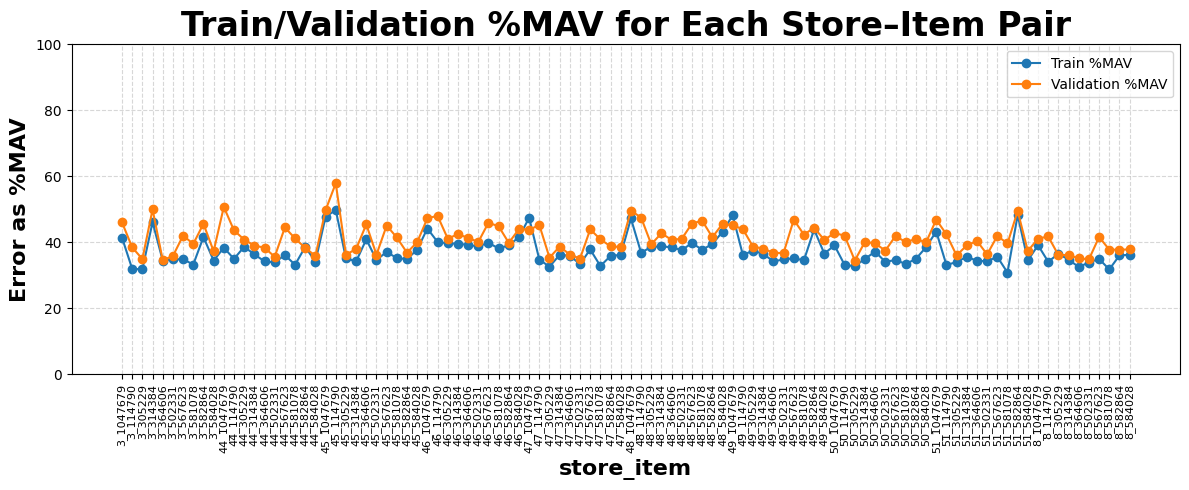

In [126]:
plot_final_percent_mav_per_sid(summary_df, title="Train/Validation %MAV for Each Store–Item Pair", 
                               fn="../output/figures/2025-06-09_TwoLayerNN_final_percent_mav_per_sid.tiff", y_lim=(0, 100))


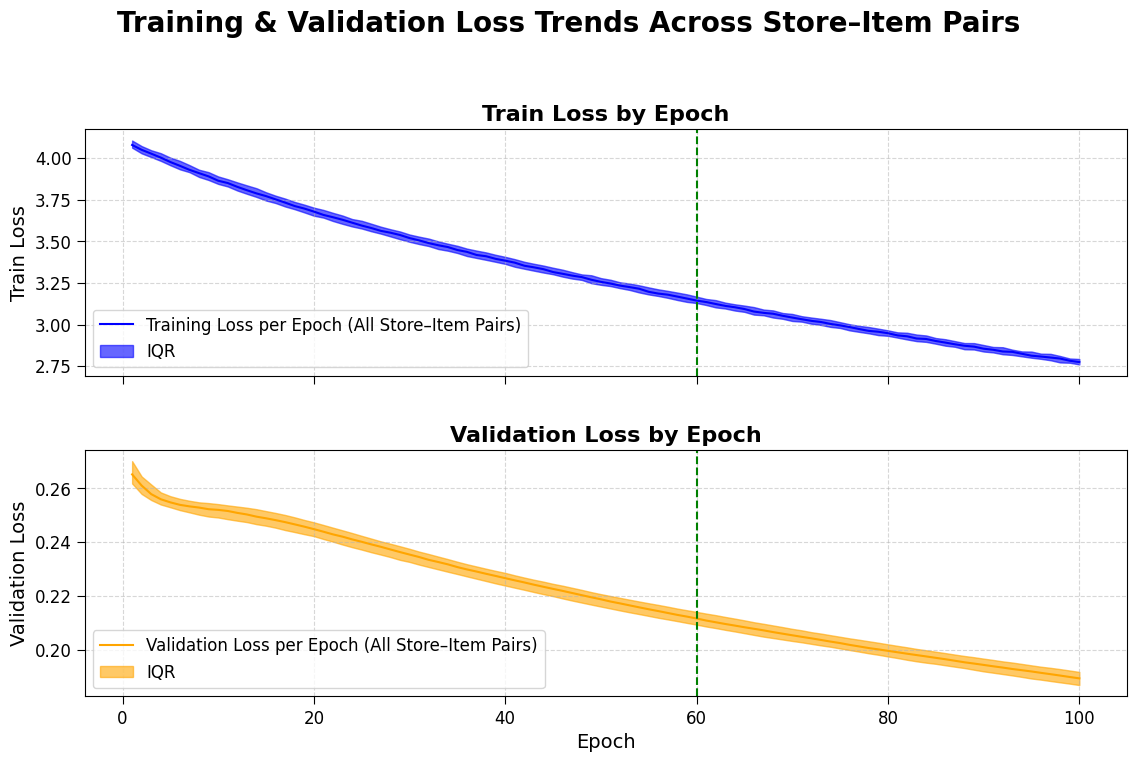

In [127]:
# plot_all_sids_losses(hist_df, 
#                      overall_title="Loss Curves for All Store Items",
# fn=f"../output/figures/all_sids_loss_curves_{today_str}.tiff")
plot_median_iqr_loss(hist_df, 
                     overall_title="Training & Validation Loss Trends Across Store–Item Pairs",
                     xvline=60,
fn=f"../output/figures/2025-06-09_TwoLayerNN_median_iqr_loss_curves_{today_str}.tiff")


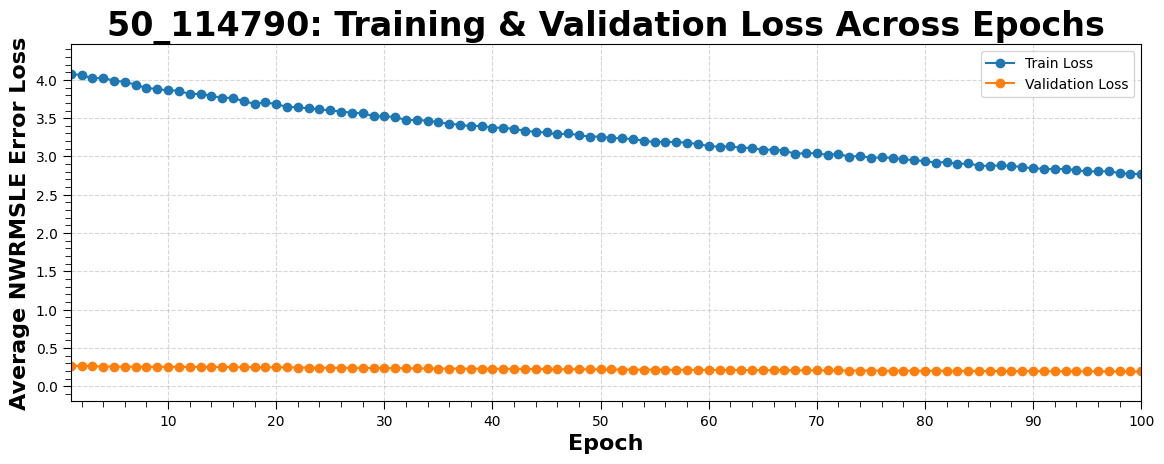

In [128]:
# to plot a single sid:
sid = "50_114790"
title = f"{sid}: Training & Validation Loss Across Epochs"
plot_loss_per_sid(hist_df, title = title,  
                  sid=sid, fn=f"../output/figures/2025-06-09_TwoLayerNN_loss_curves_{sid}_{today_str}.tiff",
                  train_col="train_loss", test_col="test_loss", y_label="Average NWRMSLE Error Loss")

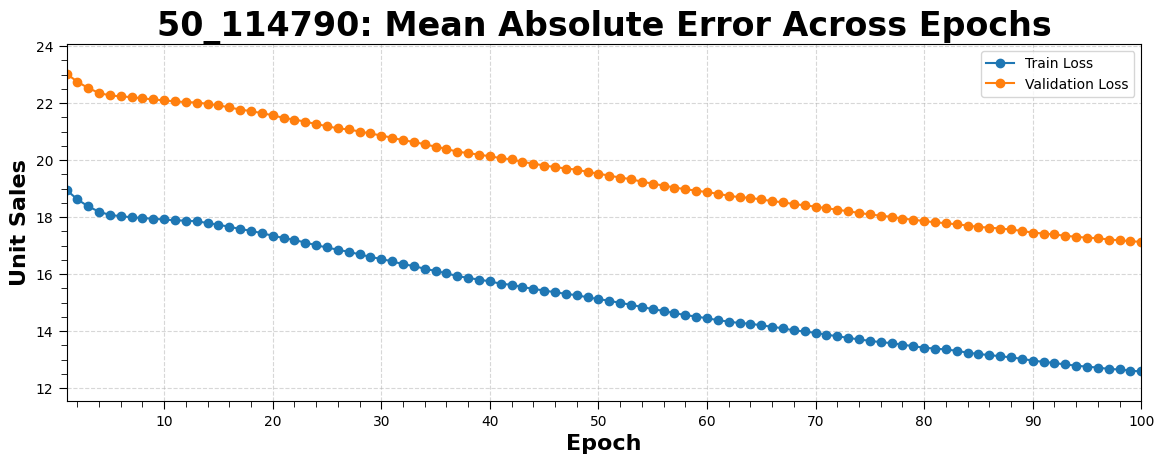

In [129]:
sid = "50_114790"
title = f"{sid}: Mean Absolute Error Across Epochs"
plot_loss_per_sid(hist_df, title=title, 
                  sid=sid, fn=f"../output/figures/2025-06-09_TwoLayerNN_loss_curves_mae_{sid}_{today_str}.tiff", 
                  train_col="train_mae", test_col="test_mae", y_label="Unit Sales")